Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


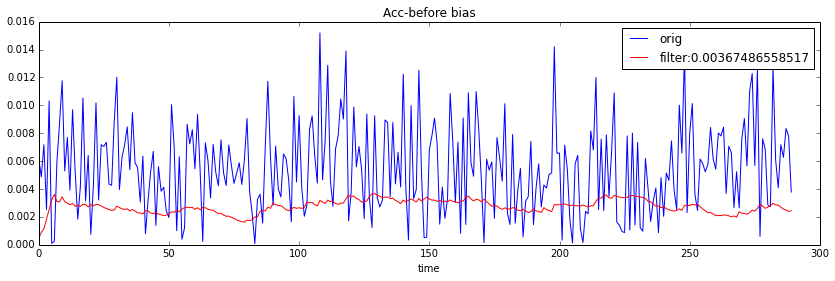

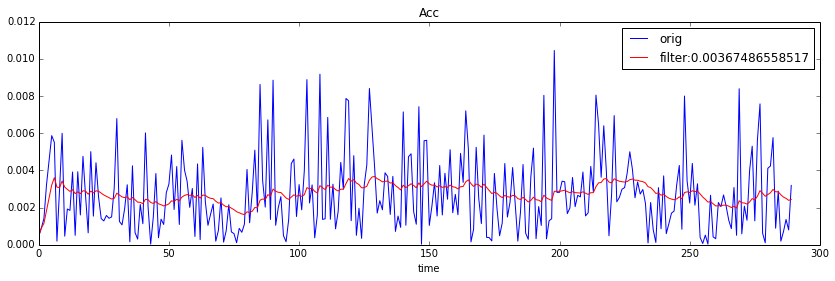

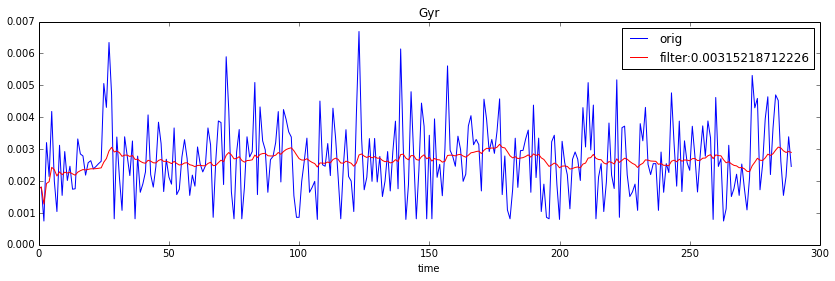

The std of original signal
[ 0.00332557  0.00356417  0.0045149   0.00186709  0.00159347  0.00158061
  0.83572128  0.82967574  0.86391397]
The std of energy signal
[ 0.00357049  0.00115131  0.86417166]


In [38]:
%pylab inline

pylab.rcParams['figure.figsize'] = (14.0, 4.0)

import numpy as np
import matplotlib.pyplot as plt
import copy

# Get the IMU signals from a file
def getSigs(fileName):
    fin = open(fileName)

    lines = fin.readlines()
    fin.close()
    
    res = []
    for str in lines:
        tmp = str.split()
        tmp = map(eval, tmp)
        res.append(tmp)

    res_array = np.array(res)
    res_array = res_array[10:, :]
    correctBias(res_array)
    
    return res_array

# Calculate the 
def energyXYZ(array):
    energy_acc = np.sqrt(np.sum(array[:,0:3]**2, 1))
    energy_gyr = np.sqrt(np.sum(array[:,3:6]**2, 1))
    energy_mag = np.sqrt(np.sum(array[:,6:]**2, 1))
    tmp = np.array([energy_acc, energy_gyr, energy_mag])
    return np.transpose(tmp)

def correctBias(array):
    #still_array = getSigs('../data/still_normal.txt')
    
    
    # TODO, the parameters may need be adjusted when in different posture
    # The bias of gyr_x, gyr_y, gyr_z, statistics from still_normal.txt
    gyr_bias = np.array([-0.01568079, 0.02071555, 0.0186753 ])
    array[:, 3:6] = array[:, 3:6] - gyr_bias


def correctBias_accEnergy(acc_energy, gyr_energy, interval=30):
    T_still_gyr_energy = 0.01
    
    acc_energy_avg = 1
    N = len(acc_energy)
    acc_energy_correctBias = np.zeros(N)
    
    for i in range(0, N, interval):
        acc_energy_seg = acc_energy[i:i+interval]
        gyr_energy_seg = gyr_energy[i:i+interval]
        # Still
        if sum(gyr_energy_seg >= T_still_gyr_energy) == 0:
            acc_energy_avg = np.mean(acc_energy_seg)
        
        acc_energy_correctBias[i:i+interval] = np.sqrt((acc_energy_seg - acc_energy_avg)**2)
        
    return acc_energy_correctBias
    

def plotEnergy(array, title_str):
    f, ax = plt.subplots(3)
    
    acc_max = (max(array[:,0]))
    acc_min = (min(array[:,0]))
    acc_range_str = str(acc_max - acc_min)
    
    ax[0].plot(array[150:180, 0], 'b', label='acc-energy:' + acc_range_str)
    ax[1].plot(array[150:180, 1], 'b', label='gyr-energy')
    ax[2].plot(array[150:180, 2], 'b', label='mag-energy')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.xlabel('time')
    ax[0].set_title(title_str)
    plt.show()
    

def calmanFilter(z, R):
    N = len(z)
    
    Q = 1e-5
    
    xhat = np.zeros(N)
    P = np.zeros(N)
    xhatminus = np.zeros(N)
    Pminus = np.zeros(N)
    K = np.zeros(N)
    
    xhat[0] = z[0]
    P[0] = 1.0
    
    
    for k in range(1, N):
        # time update
        xhatminus[k] = xhat[k-1]  #X(k|k-1) = AX(k-1|k-1) + BU(k) + W(k),A=1,BU(k) = 0
        Pminus[k] = P[k-1]+Q      #P(k|k-1) = AP(k-1|k-1)A' + Q(k) ,A=1

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R ) #Kg(k)=P(k|k-1)H'/[HP(k|k-1)H' + R],H=1
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k]) #X(k|k) = X(k|k-1) + Kg(k)[Z(k) - HX(k|k-1)], H=1
        P[k] = (1-K[k])*Pminus[k] #P(k|k) = (1 - Kg(k)H)P(k|k-1), H=1
    
    return xhat

#均值滤波
def avgFilter(z, win):
    z_filter = copy.copy(z)
    N = len(z)
    for i in range(win, N):
        z_filter[i] = np.mean(z[i-win:i])
    return z_filter
    

    
def plotOrig_filter(energy_sig, energy_sig_filter, title):
    #fig, ax = plt.subplots(2,1, sharey=True)
    #ax[0].plot(energy_sig)
    #ax[1].plot(energy_sig_filter)
    plt.plot(energy_sig, 'b', label='orig')
    plt.plot(energy_sig_filter, 'r', label='filter:'+str(max(energy_sig_filter)))
    plt.legend()
    plt.xlabel('time')
    plt.title(title)
    plt.show()

    
def test(energy_arr):
    
    energy_x = energy_array[:, 0]
    energy_y = energy_array[:, 1]
    
    energy_x_correctBias = correctBias_accEnergy(energy_x, energy_y)
    energy_x_filter = calmanFilter(energy_x_correctBias, 0.05**2)
    
    
    energy_y_filter = calmanFilter(energy_y, 0.05**2)
    
    energy_x_consBias = np.sqrt((energy_x - 1)**2)
    plotOrig_filter(energy_x_consBias, energy_x_filter, 'Acc-before bias')
    plotOrig_filter(energy_x_correctBias, energy_x_filter, 'Acc')
    plotOrig_filter(energy_y, energy_y_filter, 'Gyr')
    
    
    
    
    print('The std of original signal')
    print np.std(res_array, 0)
    print('The std of energy signal')
    print np.std(energy_array, 0)
    

if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_normal.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    test(energy_array)
    
    

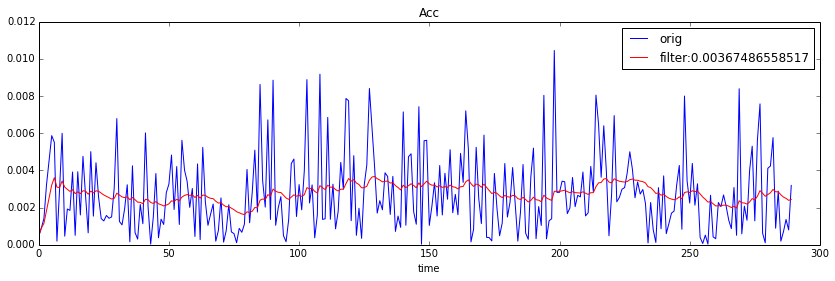

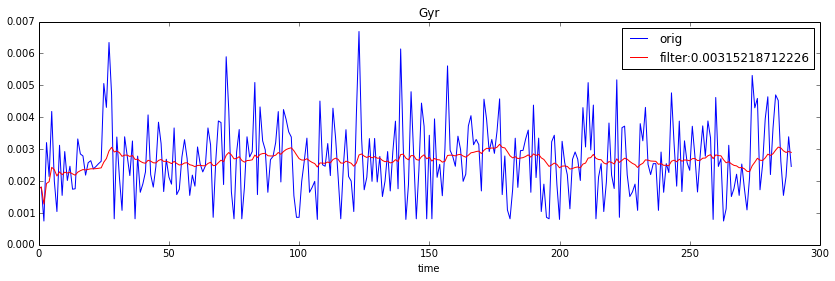

The std of original signal
[ 0.00381051  0.00401922  0.00580365  0.00183409  0.00212159  0.00191439
  0.80331033  0.82213984  0.82050602]
The std of energy signal
[ 0.00357049  0.00115131  0.86417166]


In [14]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_leftDown.txt'
    res_array = getSigs(fileName)
    
    test(energy_array)

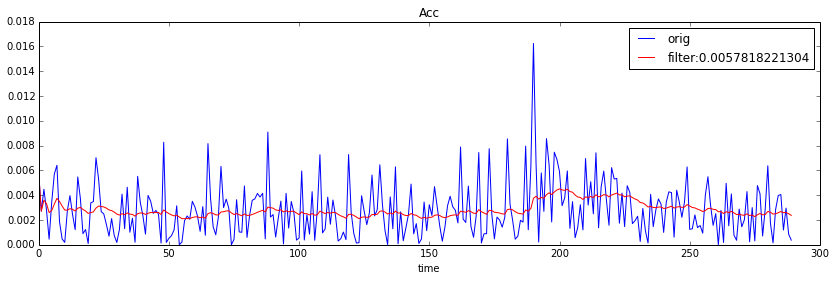

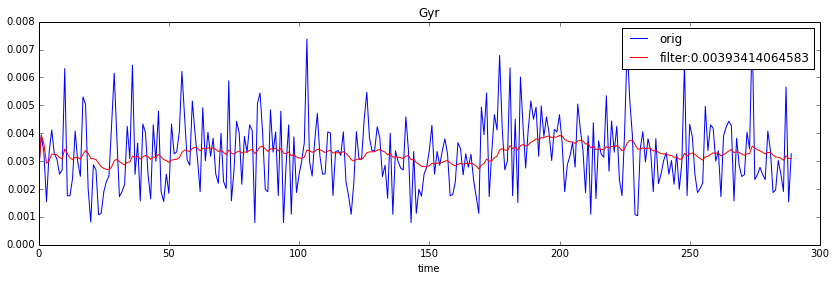

The std of original signal
[ 0.00359343  0.00337798  0.00505331  0.00195442  0.00161516  0.00172382
  0.82928097  0.84410491  0.81381379]
The std of energy signal
[ 0.0035981   0.0012766   0.81446437]


In [15]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_rightDown.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

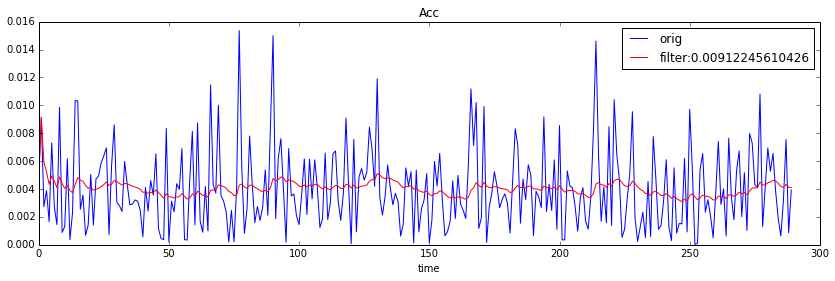

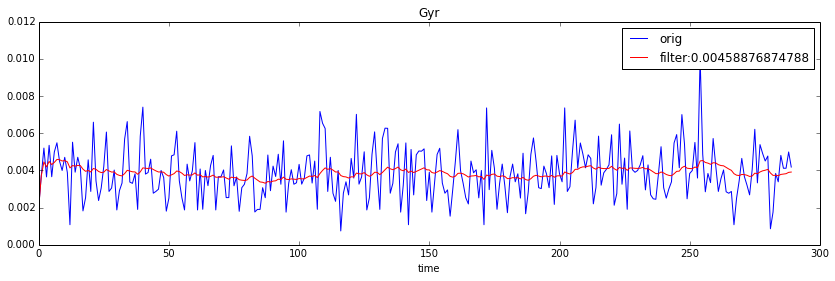

The std of original signal
[ 0.00340501  0.00333287  0.00508467  0.00190452  0.00154123  0.00162584
  0.87071003  0.81679596  0.81731994]
The std of energy signal
[ 0.00508005  0.00138583  0.84489759]


In [16]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_frontDown.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

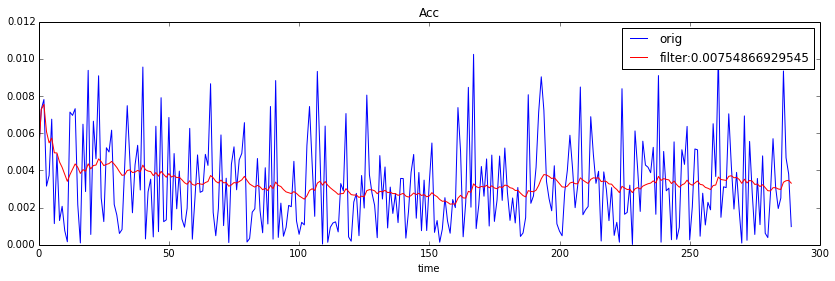

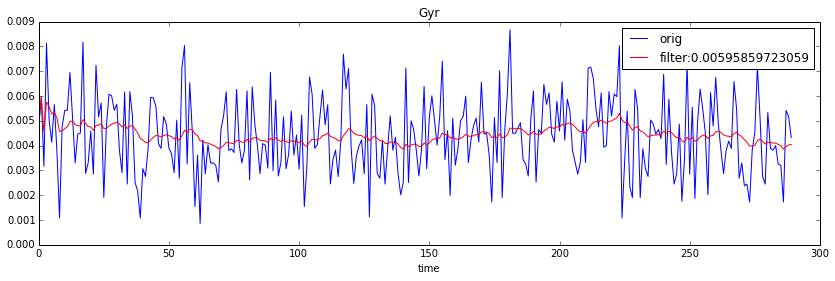

The std of original signal
[ 0.00334256  0.00334765  0.0048799   0.00173723  0.00161663  0.00171475
  0.80001106  0.9072956   0.77525557]
The std of energy signal
[ 0.00410224  0.00153458  0.78667701]


In [17]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_backDown.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

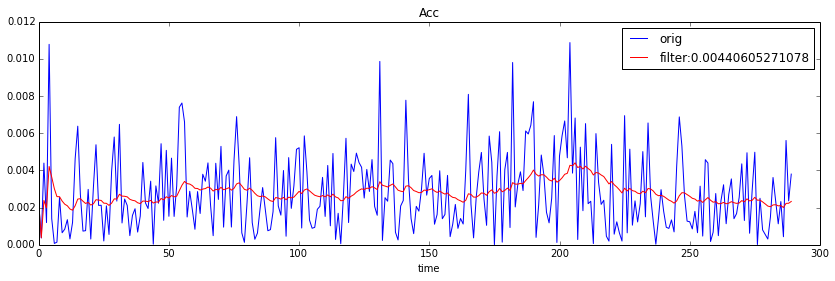

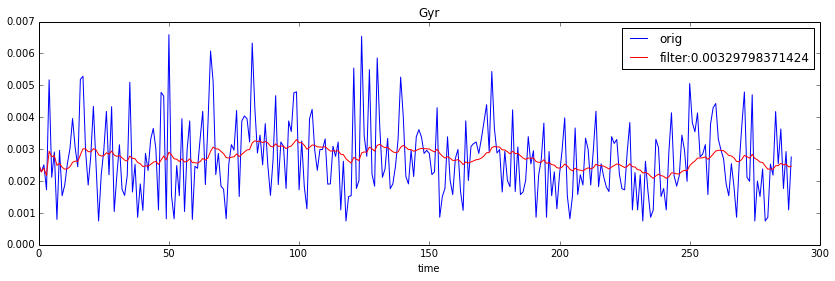

The std of original signal
[ 0.00318572  0.00354049  0.00473106  0.00183745  0.00160636  0.00162874
  0.87601136  0.78865927  0.81051244]
The std of energy signal
[ 0.00353661  0.00119271  0.83141027]


In [18]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_leftDownLean.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

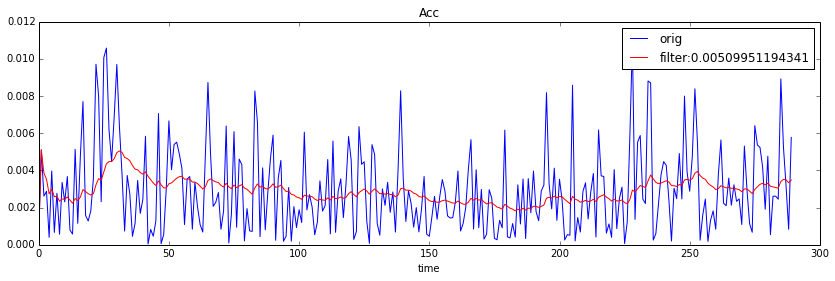

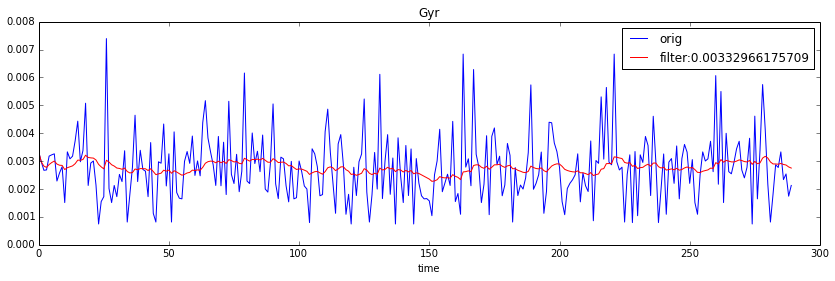

The std of original signal
[ 0.00352077  0.00371751  0.00510802  0.00189071  0.00158088  0.00171639
  0.88978986  0.81197075  0.85157734]
The std of energy signal
[ 0.00373792  0.00119305  0.83485948]


In [19]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_rightDownLean.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

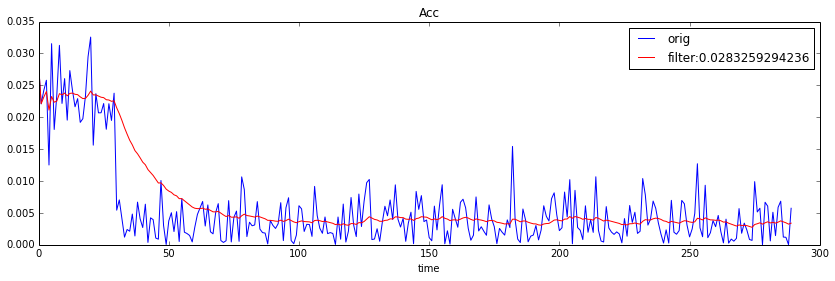

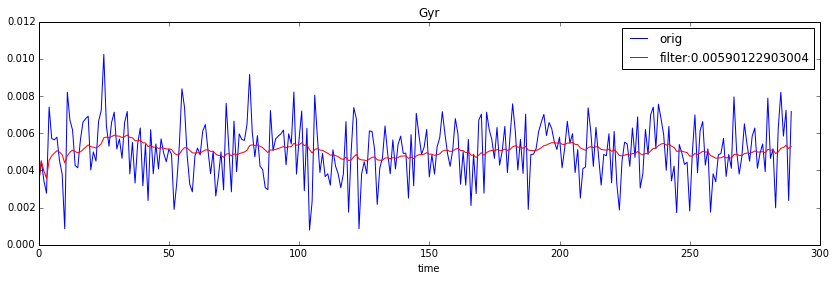

The std of original signal
[ 0.00322863  0.00395475  0.00511631  0.00226722  0.00160735  0.00169353
  0.84346136  0.83576285  0.7613603 ]
The std of energy signal
[ 0.00463676  0.00154126  0.85015111]


In [20]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_frontDownLean.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

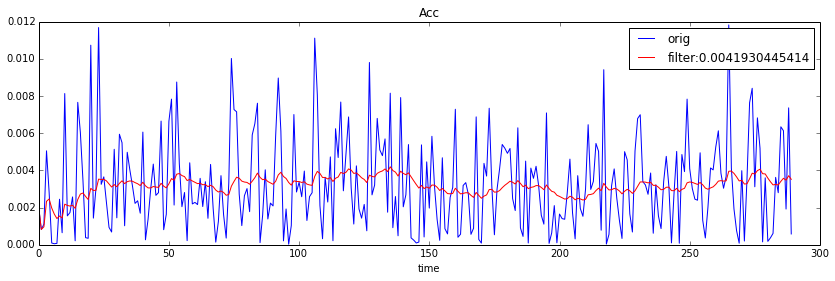

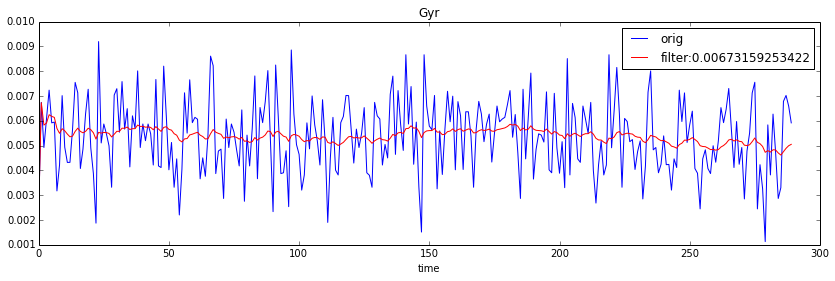

The std of original signal
[ 0.00335233  0.00382543  0.00520953  0.00170875  0.00163087  0.00171959
  0.84310087  0.8283132   0.80383319]
The std of energy signal
[ 0.00414012  0.00149854  0.82137922]


In [21]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'still_backDownLean.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

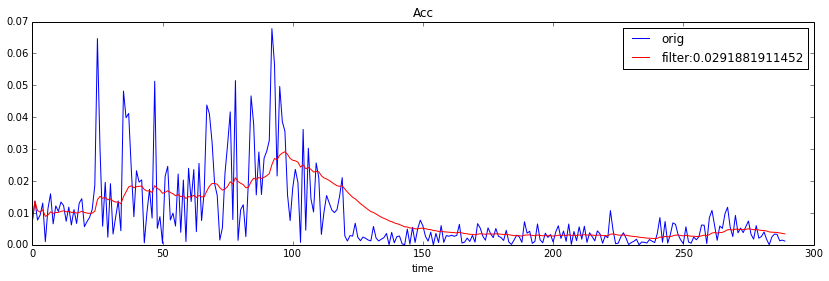

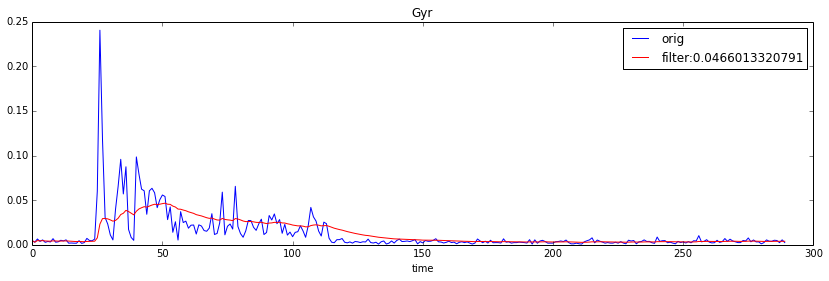

The std of original signal
[ 0.01183663  0.01422368  0.01147579  0.00820673  0.02323559  0.00670773
  0.99611013  0.85617495  0.97099367]
The std of energy signal
[ 0.01422425  0.02225407  1.09971502]


In [22]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_xMove_uniform.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

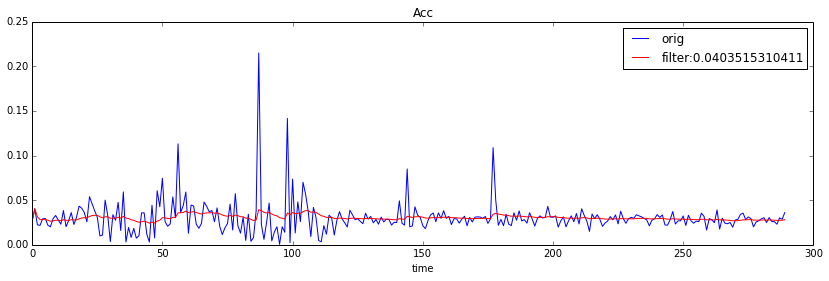

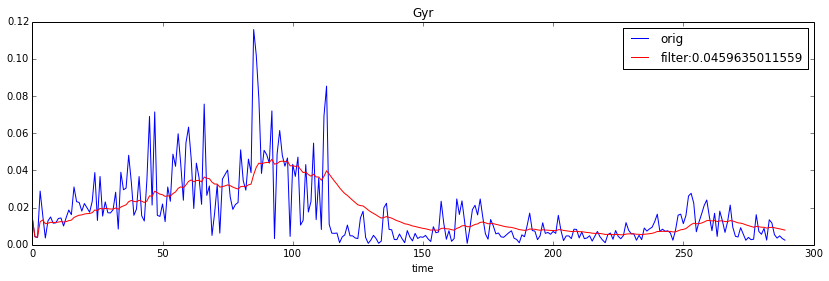

The std of original signal
[ 0.00711309  0.01331356  0.01957204  0.0160494   0.00991611  0.01623175
  0.9190237   0.85617683  0.88218031]
The std of energy signal
[ 0.01963556  0.01806849  0.91045797]


In [23]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_yMove_uniform.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

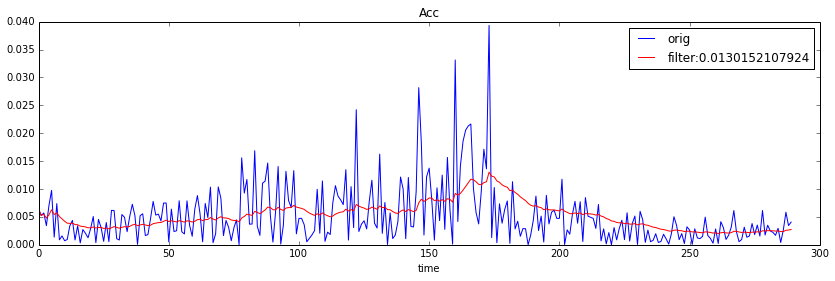

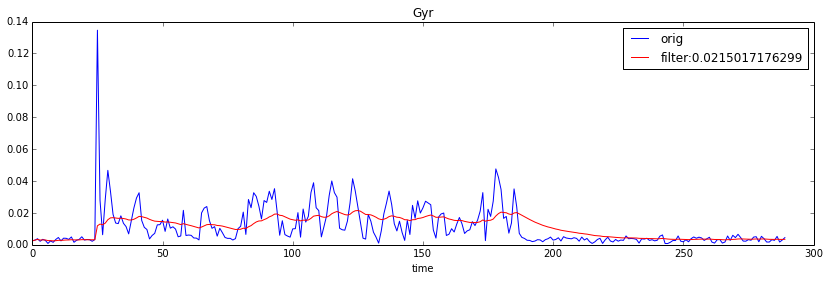

The std of original signal
[ 0.00415856  0.00707012  0.01093468  0.00354176  0.01620896  0.00245684
  0.87194628  0.91690956  1.39774232]
The std of energy signal
[ 0.00715198  0.01254686  1.09292438]


In [24]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_zMove_uniform.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

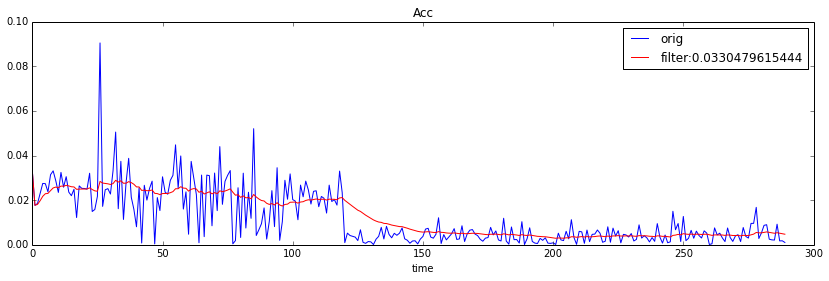

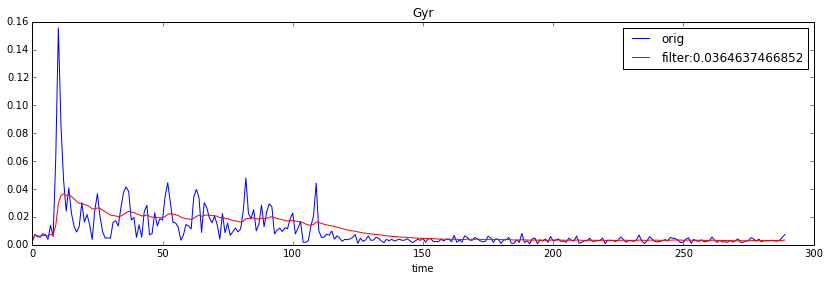

The std of original signal
[ 0.00599803  0.00710843  0.00966982  0.00830188  0.00209196  0.01451726
  0.88055632  0.90358442  0.7932999 ]
The std of energy signal
[ 0.00966362  0.01401423  0.86426711]


In [25]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_xyz_Move_uniform1.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

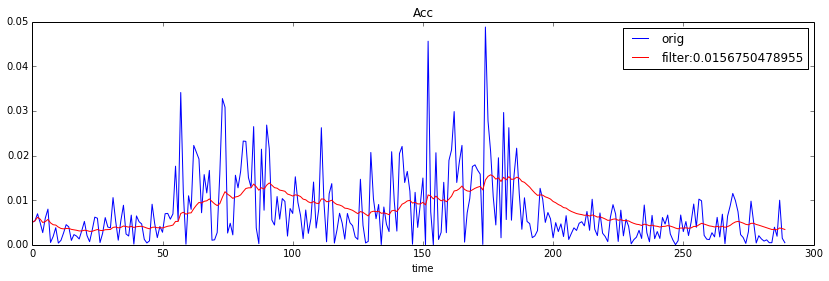

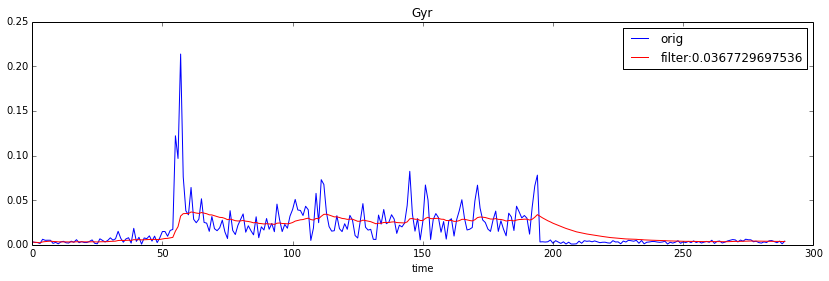

The std of original signal
[ 0.00456685  0.0098939   0.01075616  0.02024148  0.00256698  0.018237
  0.95800085  0.90912678  0.80352678]
The std of energy signal
[ 0.01081142  0.02157062  0.85119152]


In [26]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_xyz_Move_uniform2.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

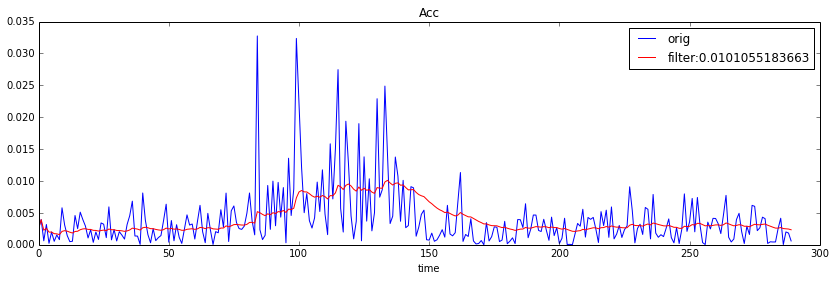

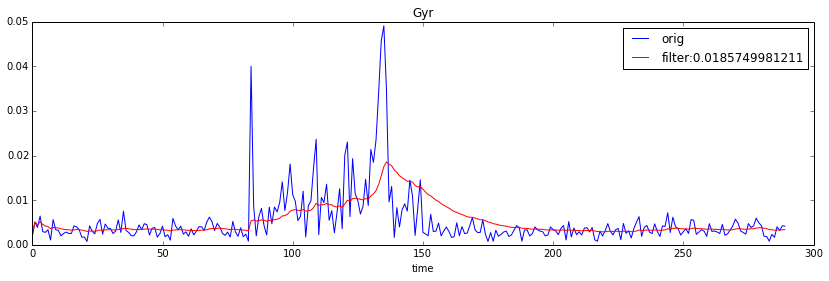

The std of original signal
[ 0.00365207  0.0059298   0.00740903  0.00308012  0.00687409  0.00186586
  0.82602591  0.88432532  0.79686398]
The std of energy signal
[ 0.00624058  0.00614753  0.86198056]


In [27]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_xyz_Move_uniform3.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

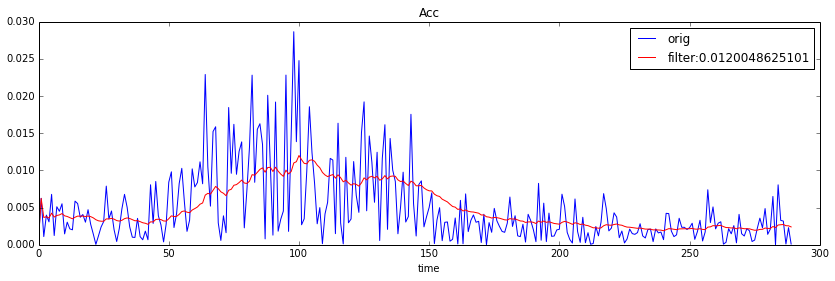

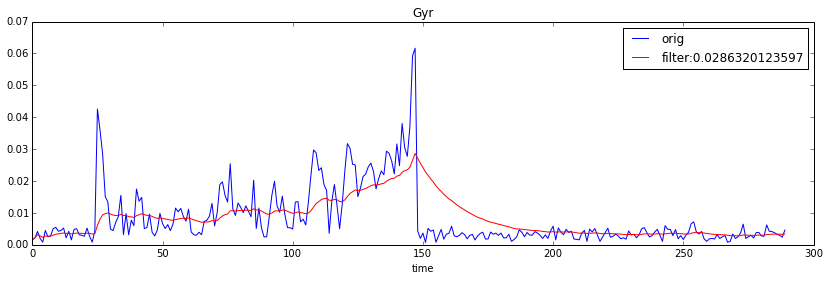

The std of original signal
[ 0.00526286  0.00681738  0.00704926  0.00315425  0.0109111   0.00215543
  1.8624494   0.78117907  0.98531418]
The std of energy signal
[ 0.00696166  0.00924065  1.21386643]


In [28]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_xyz_Move_uniform4.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

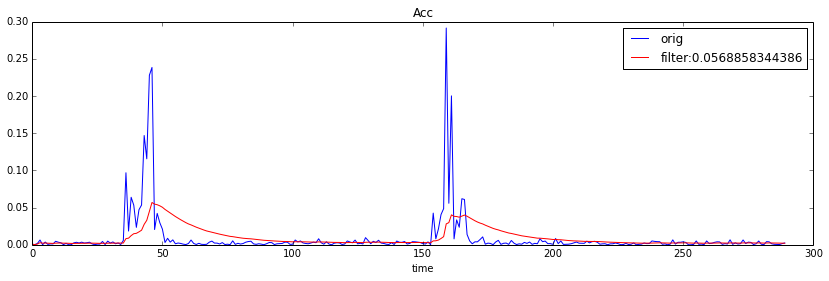

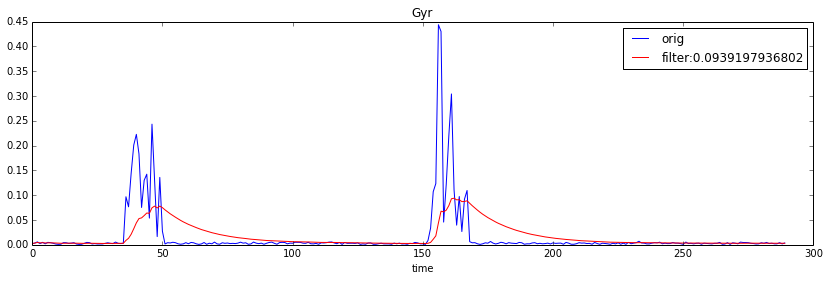

The std of original signal
[ 0.03303194  0.03283416  0.06306427  0.02317417  0.05087237  0.00571164
  0.91685991  0.90815575  0.99678421]
The std of energy signal
[ 0.03269273  0.05352359  0.84134496]


In [29]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_xyz_Move_speedup1.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

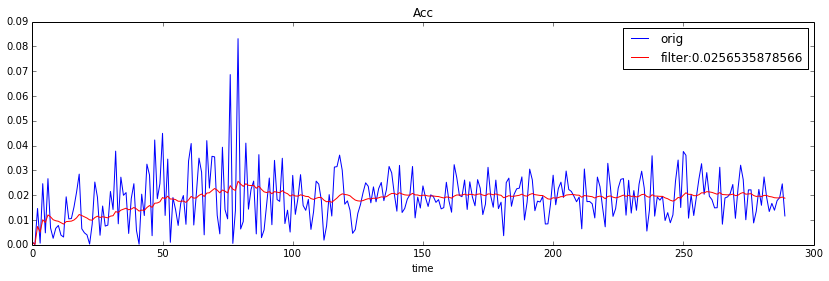

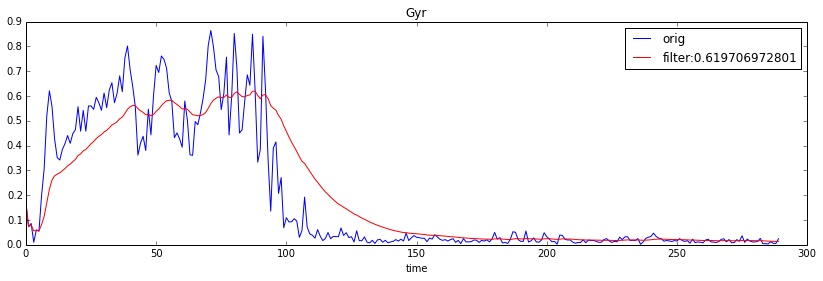

The std of original signal
[  9.05157332e-03   4.35646710e-01   2.90788145e-01   2.63066731e-01
   2.77836652e-02   2.26039610e-02   1.00568816e+00   1.62368059e+01
   1.63039275e+01]
The std of energy signal
[  1.10374126e-02   2.57641235e-01   1.21578303e+01]


In [30]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_xRotate_uniform_anticlock.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

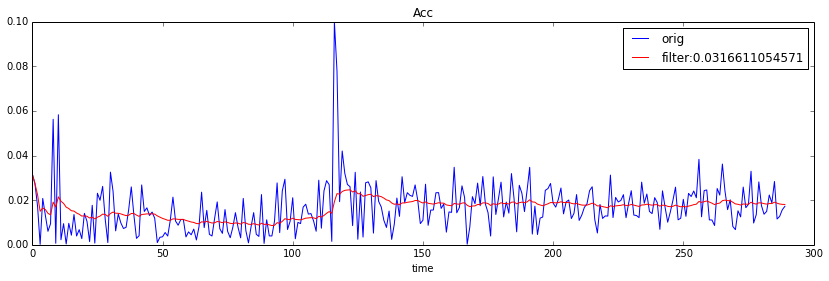

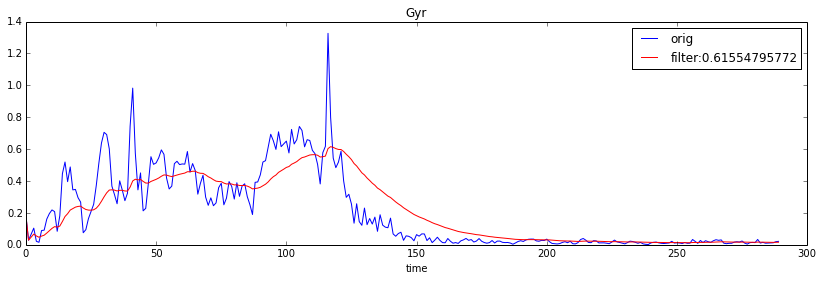

The std of original signal
[  2.90741030e-02   5.44118175e-01   2.91383100e-01   2.44783381e-01
   3.25014797e-02   2.23010611e-02   1.46283478e+00   2.72111326e+01
   7.78228076e+00]
The std of energy signal
[ 0.0156541   0.23860533  4.30199224]


In [31]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_xRotate_uniform_clock.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

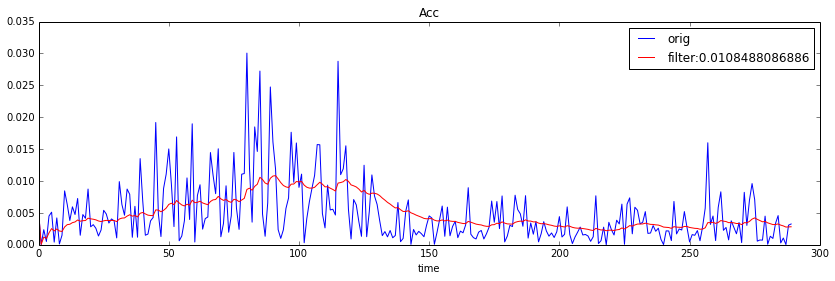

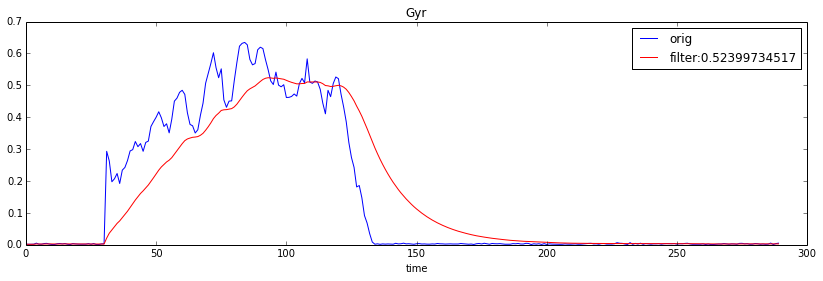

The std of original signal
[  8.68823301e-03   6.82904828e-03   1.43359761e-02   2.42864758e-03
   2.16277511e-01   2.46362188e-02   1.54738353e+01   1.15842496e+00
   7.24418944e+00]
The std of energy signal
[ 0.0068798   0.21642061  2.98817764]


In [32]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_yRotate_uniform_anticlock.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

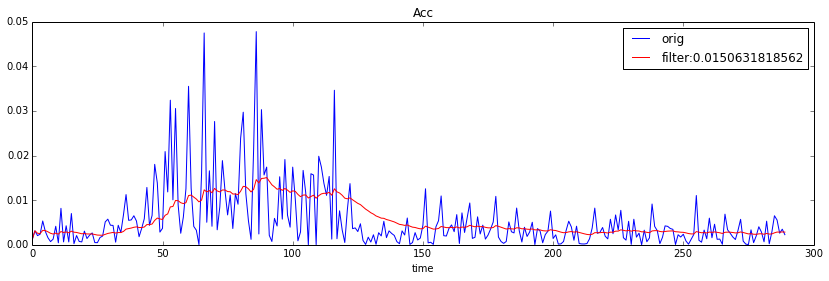

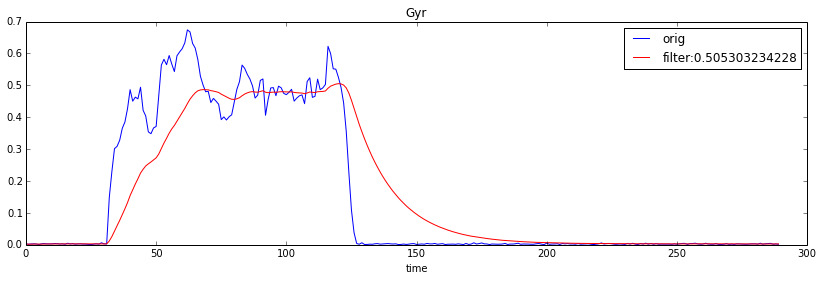

The std of original signal
[  8.33927625e-03   9.27700359e-03   1.25472359e-02   2.77200396e-03
   2.26861468e-01   2.55133709e-02   8.78174130e+00   1.69313084e+00
   1.47397841e+01]
The std of energy signal
[  9.02609198e-03   2.27092011e-01   1.01458365e+01]


In [33]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_yRotate_uniform_clock.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

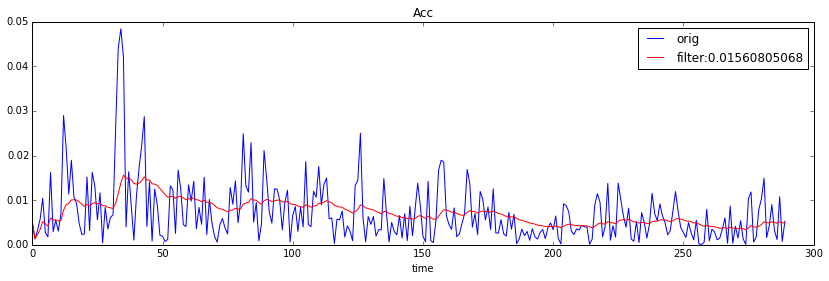

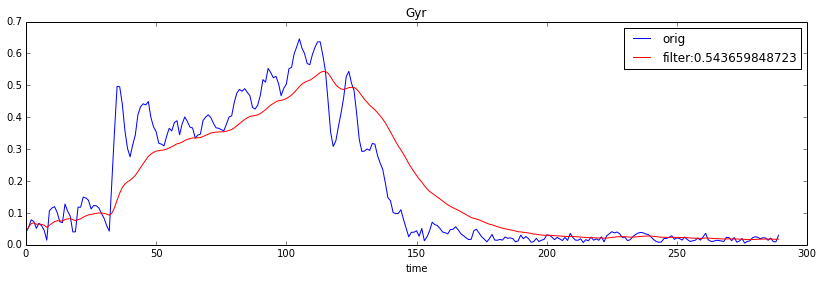

The std of original signal
[  0.38497823   0.43509148   0.06968589   0.03155117   0.03918096
   0.20884431   6.44222475  29.63216338   3.43824859]
The std of energy signal
[ 0.00906596  0.19786582  3.26641086]


In [34]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_zRotate_uniform_anticlock.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

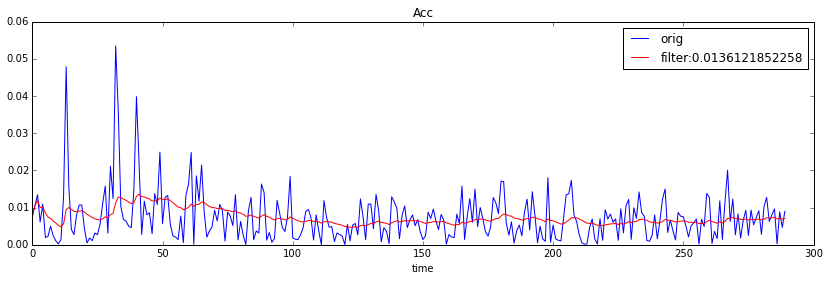

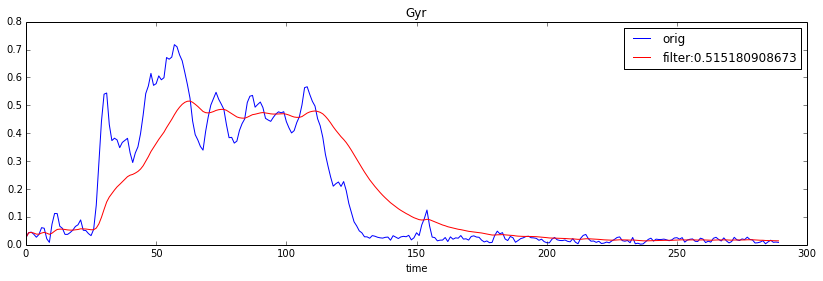

The std of original signal
[  0.35763243   0.40706389   0.05456635   0.02837342   0.03365596
   0.21735454  27.04553059   8.6900875    1.46721198]
The std of energy signal
[ 0.00970964  0.2128051   1.09187203]


In [35]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_zRotate_uniform_clock.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

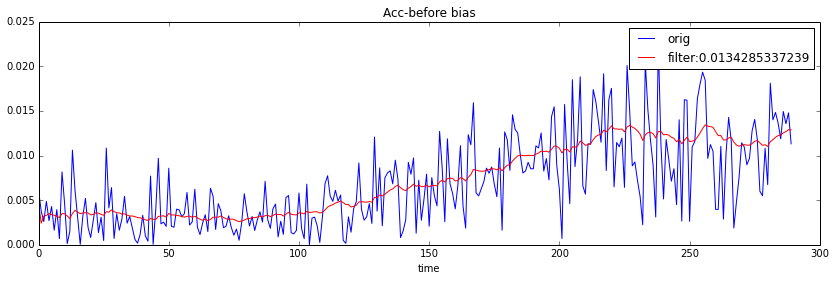

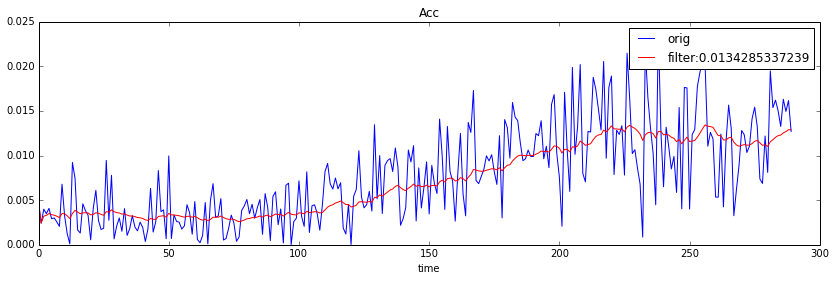

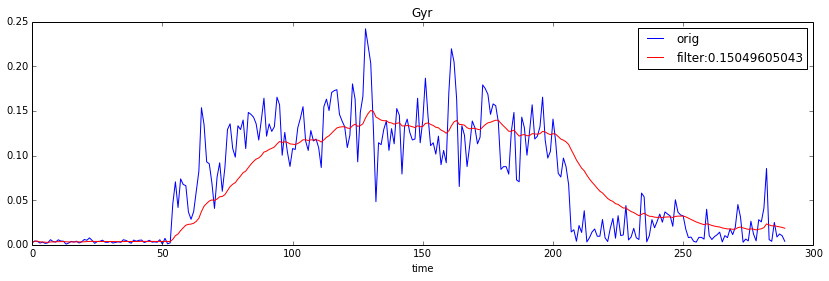

The std of original signal
[  3.61666595e-03   1.12775971e-01   2.44566033e-01   6.52184517e-02
   1.61696003e-03   1.88304756e-03   7.74124985e-01   8.20397816e+00
   9.41418559e+00]
The std of energy signal
[ 0.00645734  0.06163658  4.67295374]


In [39]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'multiStates.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

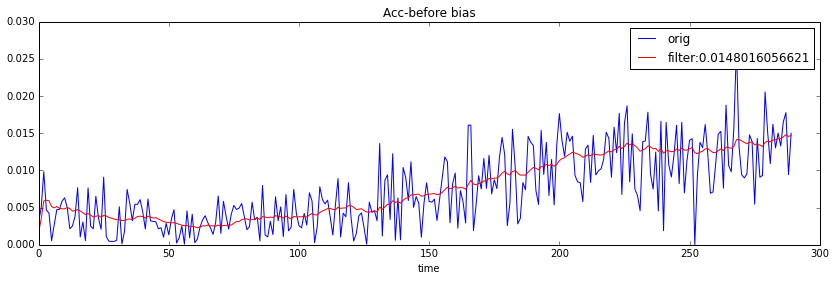

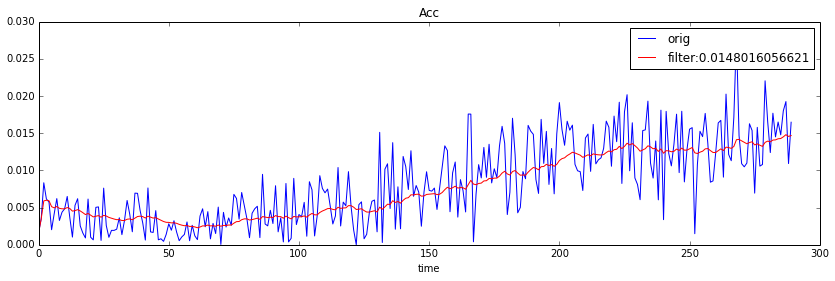

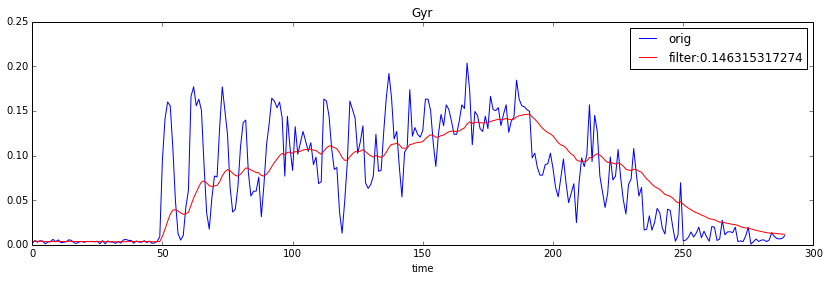

The std of original signal
[  3.72981796e-03   1.25224683e-01   2.44605799e-01   6.09298610e-02
   1.65175043e-03   1.80211511e-03   8.45784337e-01   1.90125542e+00
   1.40037430e+01]
The std of energy signal
[  6.83404952e-03   5.87974941e-02   8.83278492e+00]


In [40]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'multiStates2.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

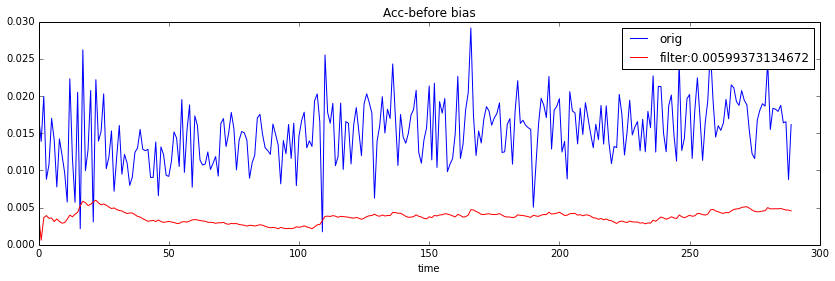

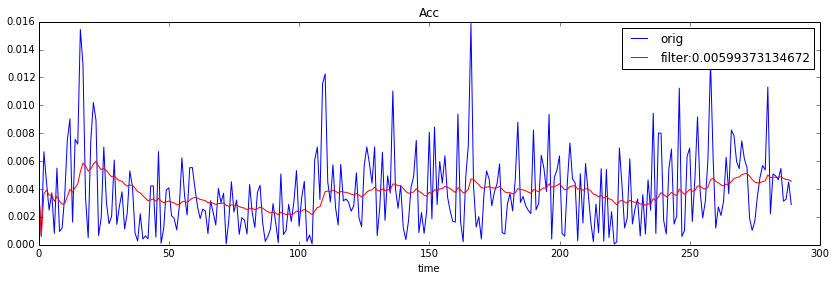

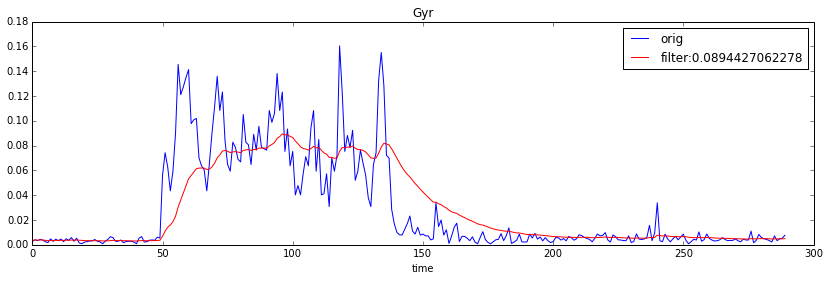

The std of original signal
[  3.27466950e-03   2.94665853e-02   1.00812308e-01   4.11583189e-02
   1.42446879e-03   1.63847697e-03   8.47293711e-01   8.76482255e-01
   4.67448363e+00]
The std of energy signal
[ 0.00430225  0.03919898  2.54811604]


In [41]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'multiStates3.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

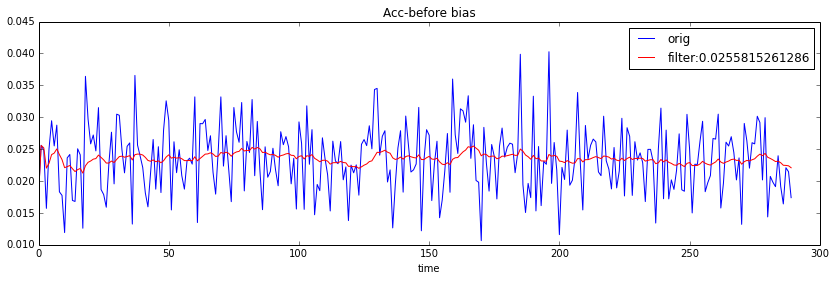

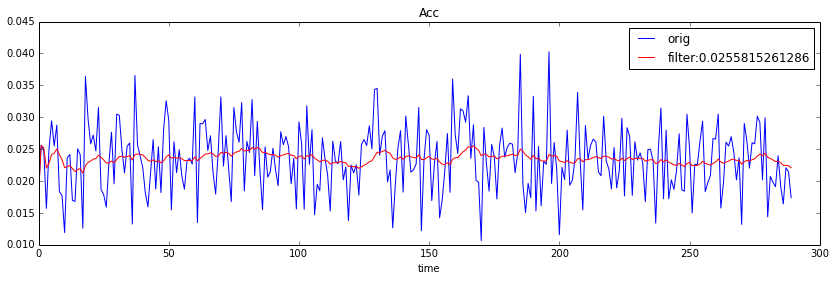

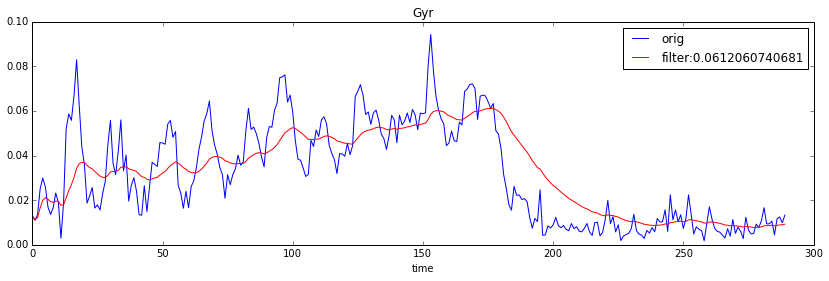

The std of original signal
[ 0.00705487  0.0054919   0.00529394  0.00648016  0.00894401  0.02523756
  3.58102849  1.55866862  0.82704551]
The std of energy signal
[ 0.0053095   0.02217971  1.08074889]


In [42]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'multiStates4.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

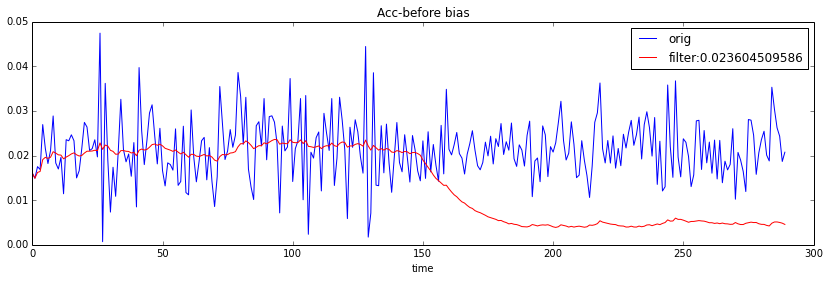

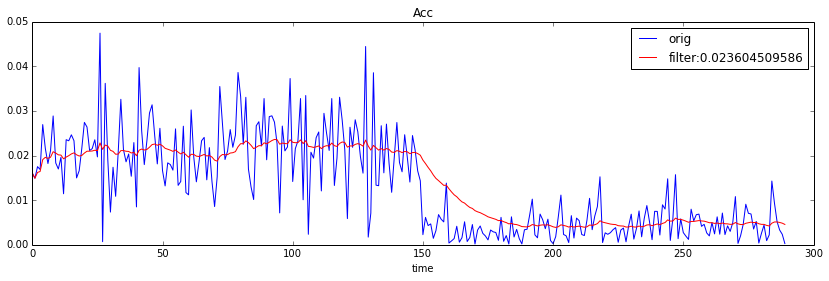

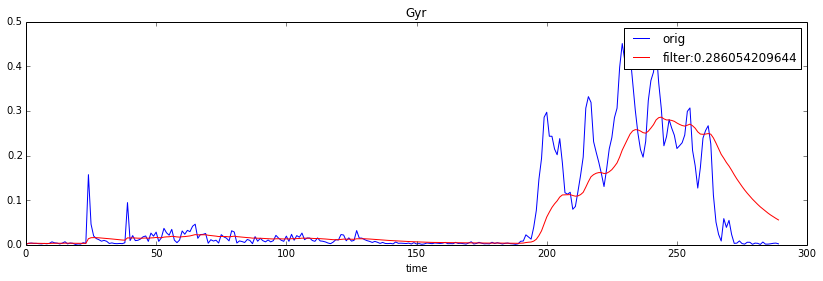

The std of original signal
[  7.42714099e-03   1.10408512e-02   7.33547514e-03   5.61784631e-03
   6.86453084e-03   1.14422891e-01   1.77310344e+00   6.19864969e+00
   8.66286341e-01]
The std of energy signal
[ 0.00750624  0.10908623  0.89744925]


In [43]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_rotate_move1.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

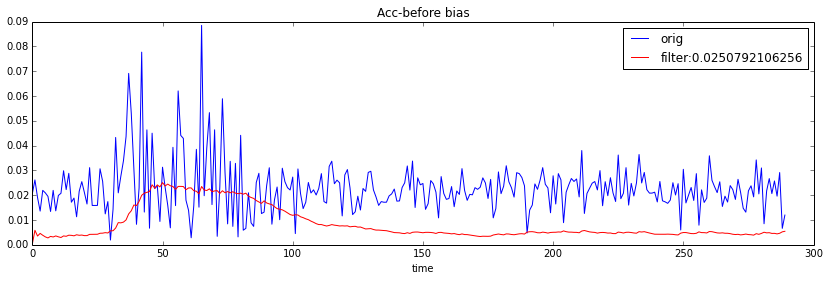

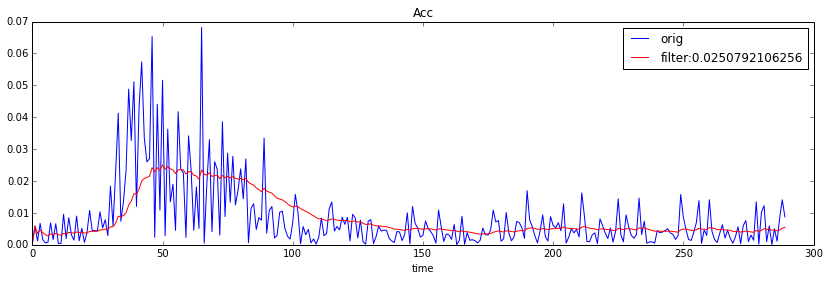

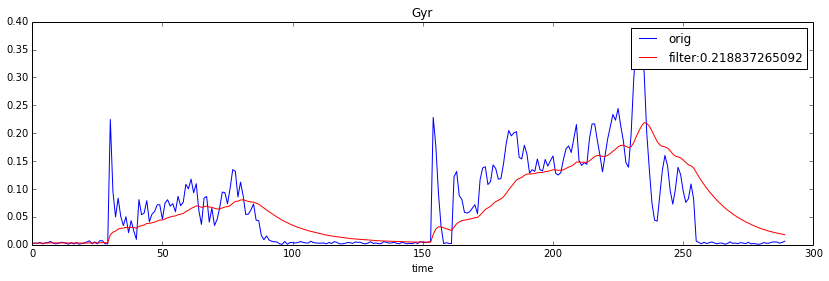

The std of original signal
[ 0.01426048  0.01364646  0.01381099  0.00583828  0.00683996  0.09234637
  3.15693843  4.91115894  0.92851605]
The std of energy signal
[ 0.01391825  0.07621382  1.016488  ]


In [44]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_rotate_move2.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

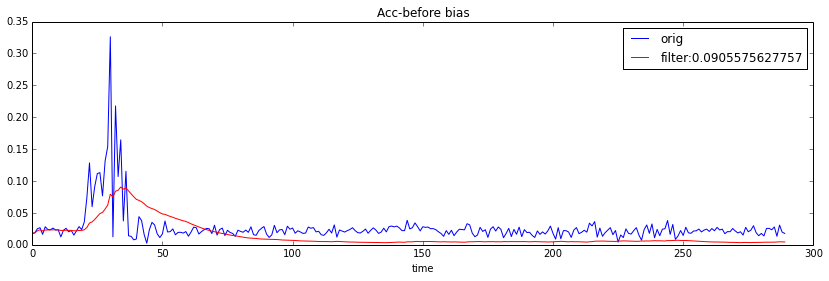

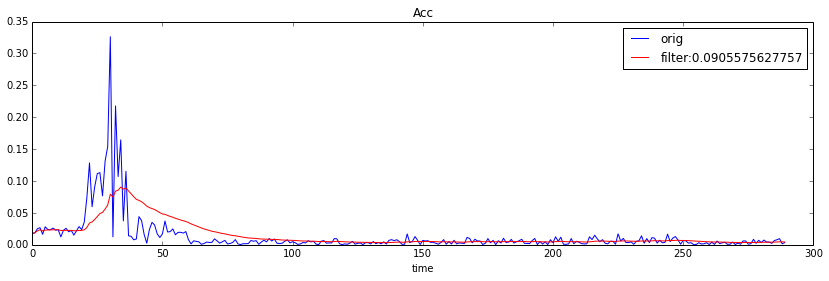

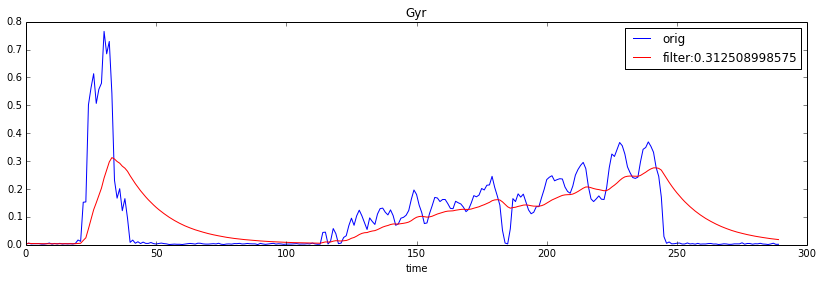

The std of original signal
[ 0.06447661  0.03040947  0.03263423  0.01106575  0.01557502  0.13887482
  3.94726486  9.00628206  0.96469551]
The std of energy signal
[ 0.0354278   0.1380611   1.00817126]


In [45]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_rotate_move3.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

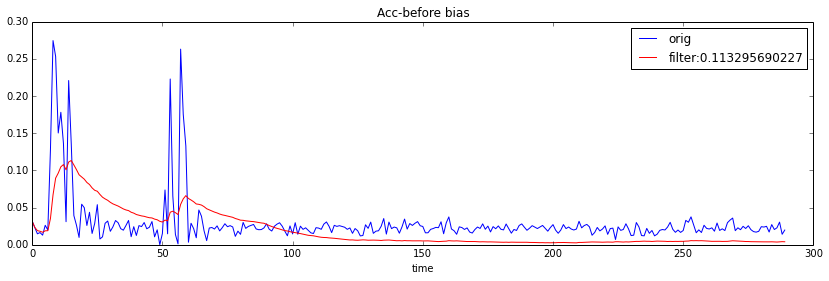

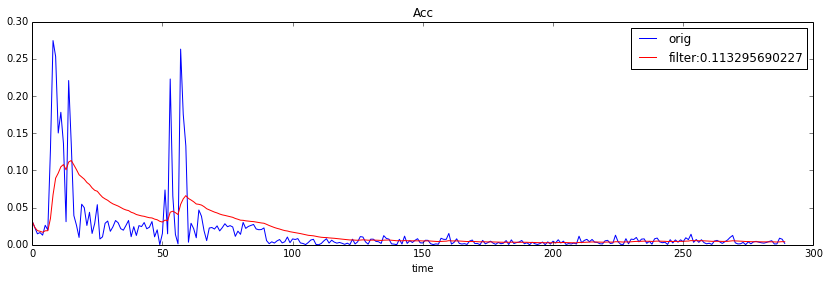

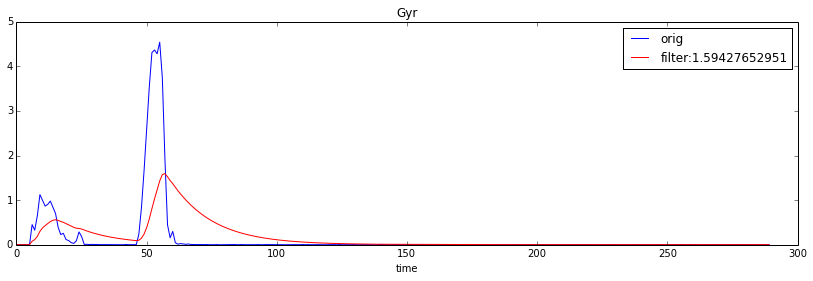

The std of original signal
[  0.09411861   0.05968656   0.03884372   0.0142301    0.03029007
   0.63993553   1.4407137   13.16153194   0.97322839]
The std of energy signal
[ 0.04214053  0.63788383  1.26962992]


In [46]:
if __name__ == '__main__':
    
    dir = '../data/'
    fileName = dir + 'motion_rotate_move4.txt'
    res_array = getSigs(fileName)
    
    energy_array = energyXYZ(res_array)
    
    
    test(energy_array)

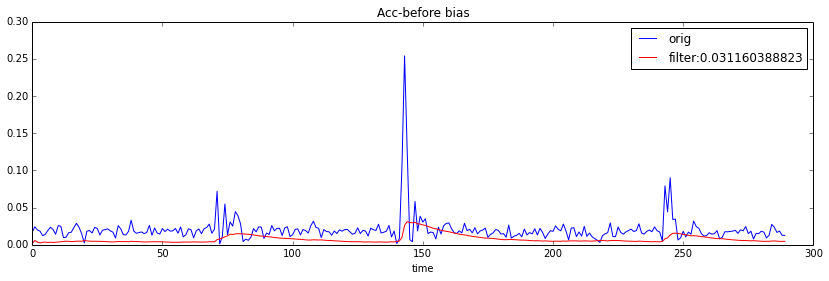

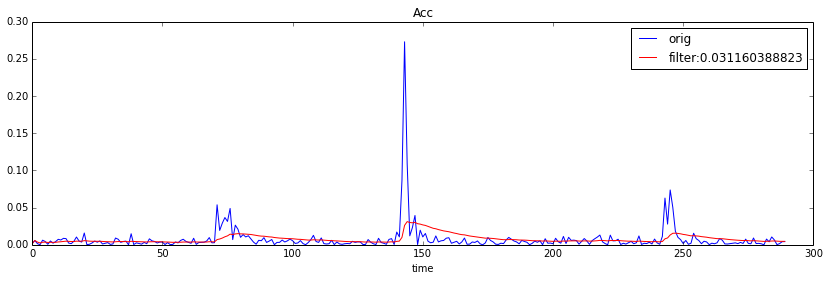

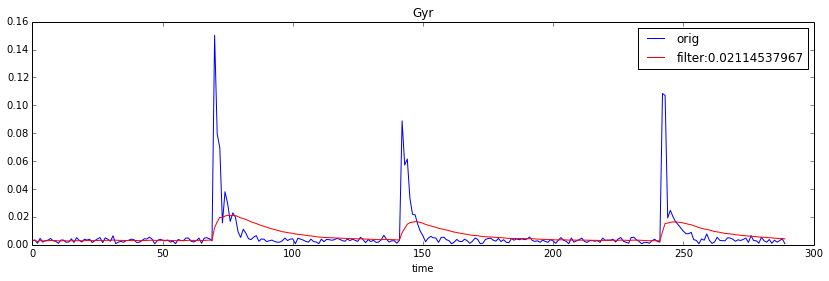

The std of original signal
[ 0.0152244   0.01866222  0.02137725  0.01161879  0.008316    0.00884336
  0.94013994  0.83539138  0.83261988]
The std of energy signal
[ 0.02099487  0.01558128  0.80723332]


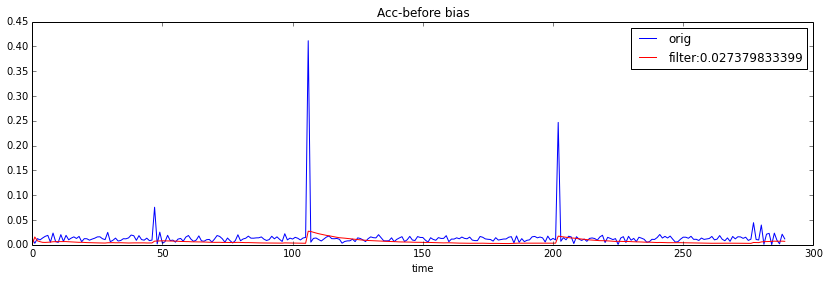

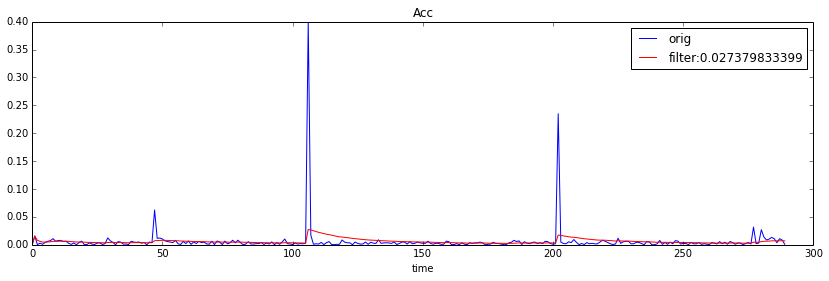

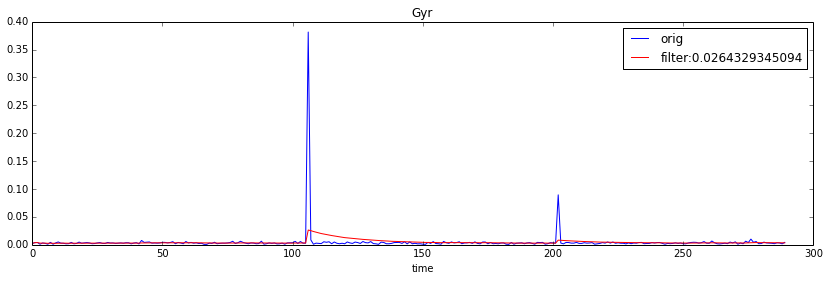

The std of original signal
[ 0.00900746  0.02286613  0.04416902  0.01809079  0.00516341  0.01365559
  0.82745952  0.84448022  0.78763773]
The std of energy signal
[ 0.02785249  0.02275724  0.78519176]


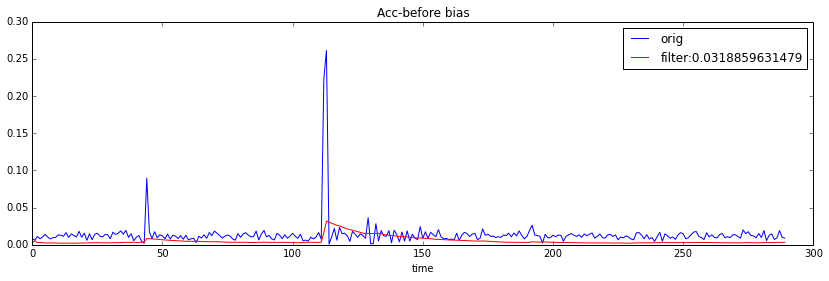

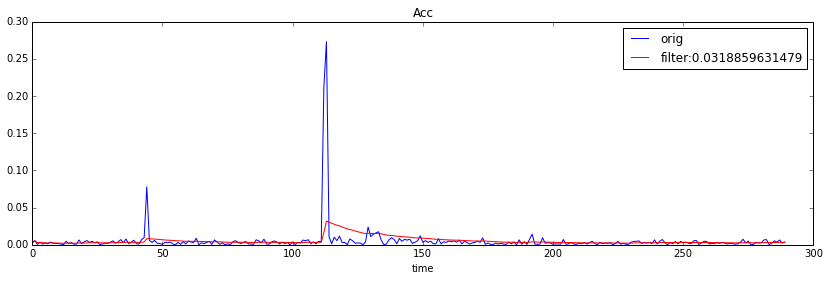

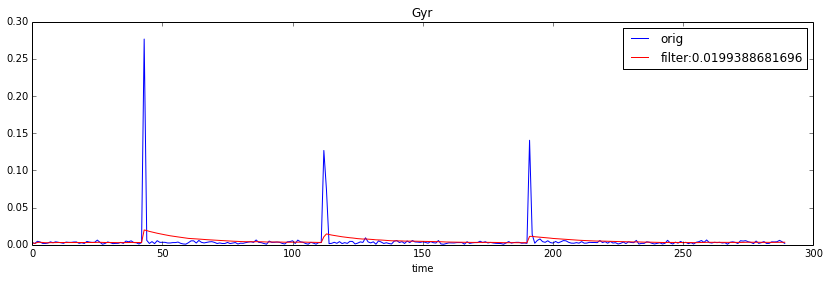

The std of original signal
[ 0.0047748   0.02054864  0.01036631  0.01436065  0.00497358  0.0136309
  0.87071321  0.80702973  0.82772144]
The std of energy signal
[ 0.02129853  0.0197686   0.87359758]


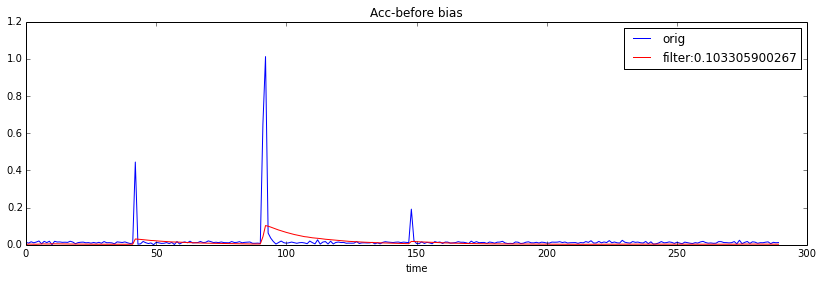

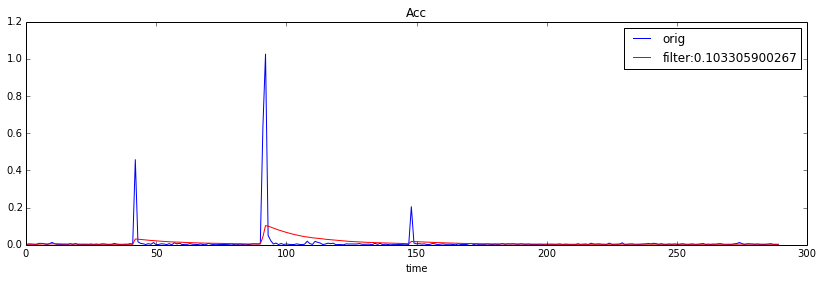

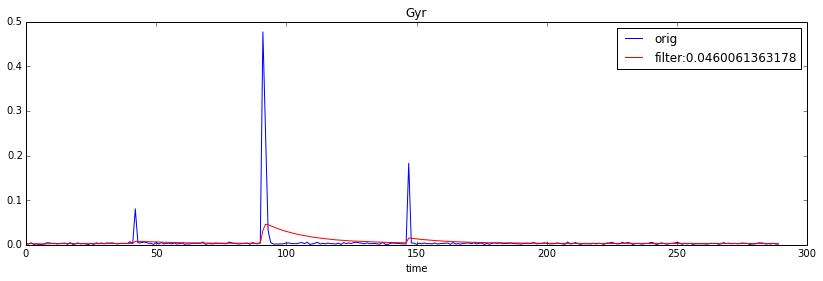

The std of original signal
[ 0.01209259  0.08092045  0.02554763  0.02165774  0.00303758  0.02596053
  0.8233443   0.86222761  0.88097379]
The std of energy signal
[ 0.0767799   0.03341344  0.90613224]


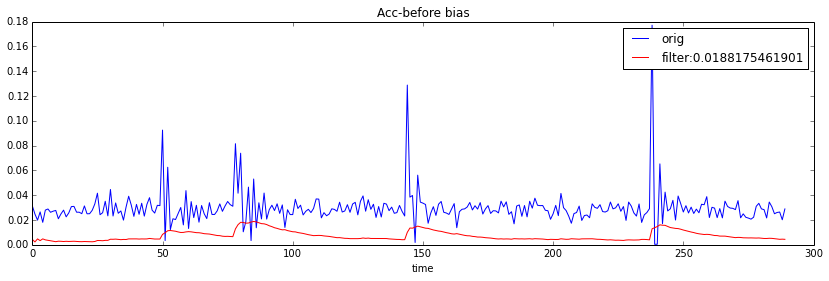

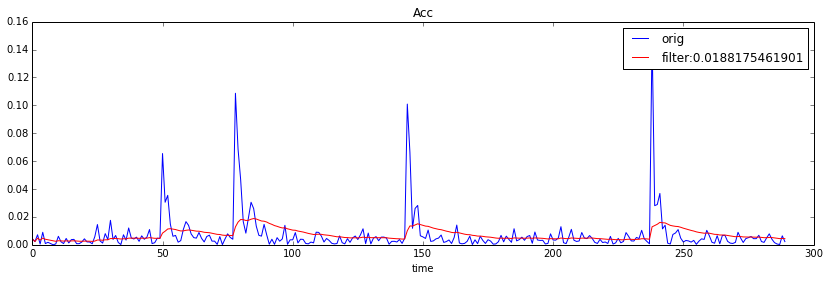

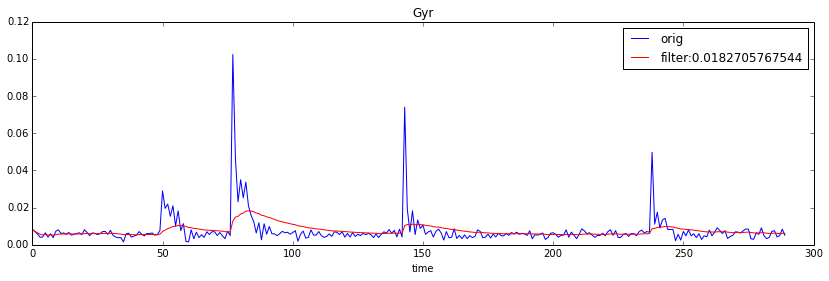

The std of original signal
[ 0.0081871   0.00675371  0.01653404  0.00688813  0.00677903  0.00346989
  0.83039781  0.82438857  0.86161658]
The std of energy signal
[ 0.01632719  0.00873732  0.88829836]


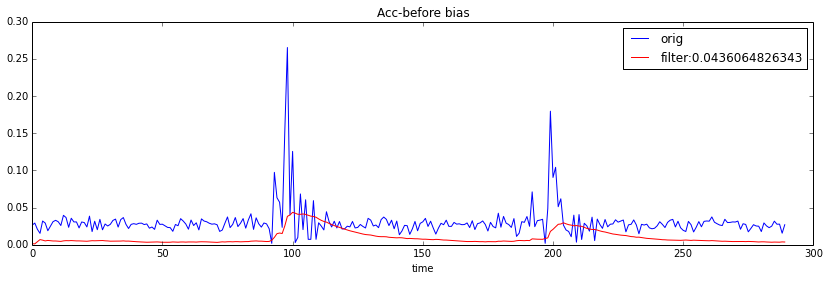

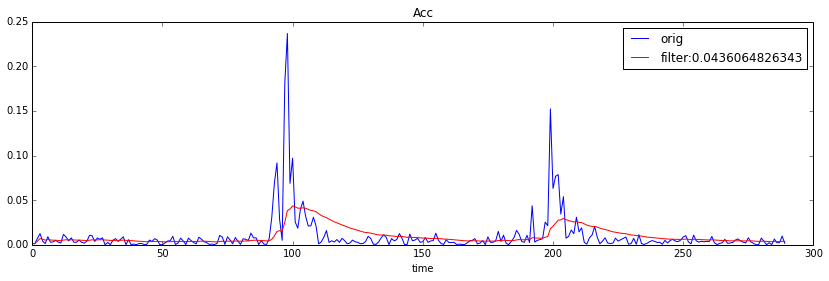

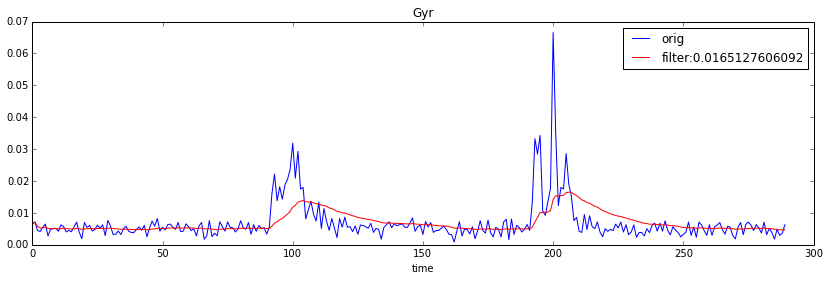

The std of original signal
[ 0.00701021  0.00537804  0.02525316  0.00279968  0.00747337  0.00218091
  0.86412197  0.88574675  0.84854317]
The std of energy signal
[ 0.02511353  0.00636789  0.80808154]


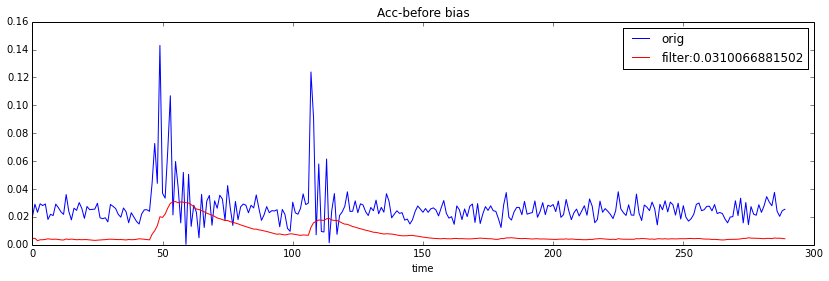

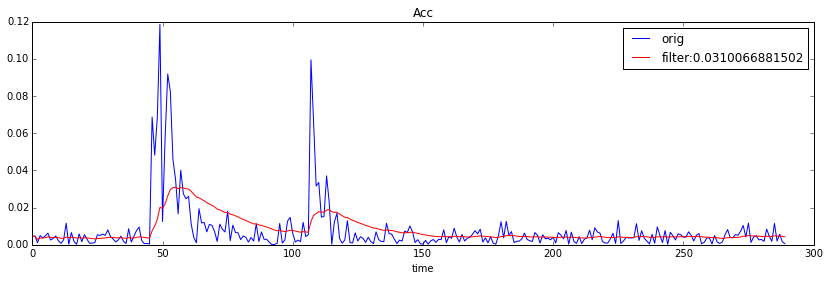

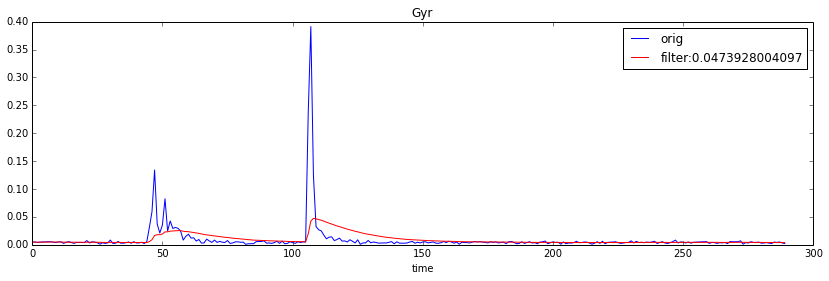

The std of original signal
[ 0.01254982  0.01698669  0.01712171  0.00919564  0.01147491  0.02639863
  0.94715696  0.87493998  0.87581036]
The std of energy signal
[ 0.01653767  0.02918738  0.86443273]


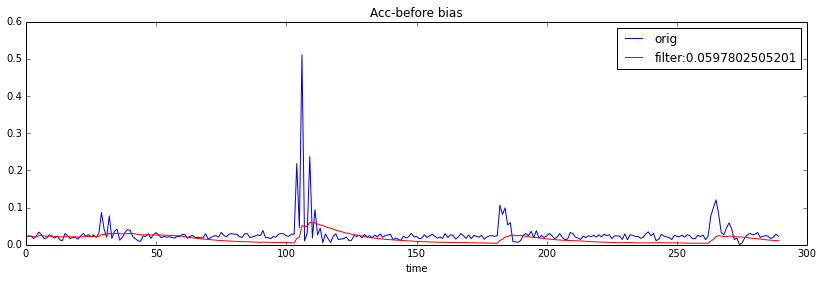

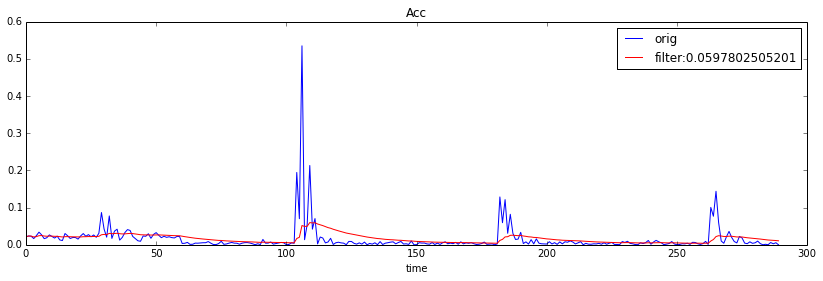

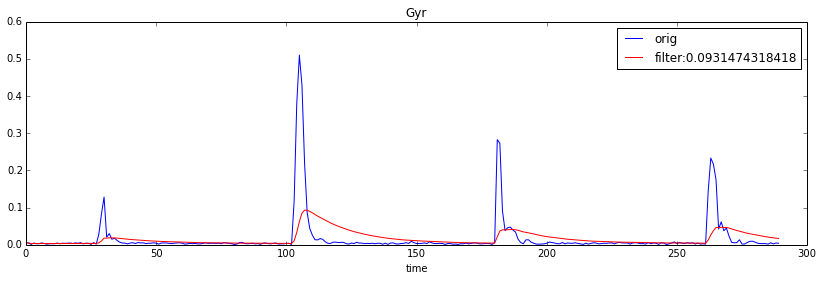

The std of original signal
[ 0.02595992  0.02553732  0.04065202  0.02752229  0.02315534  0.04686942
  1.19900791  0.85598928  0.817909  ]
The std of energy signal
[ 0.04132409  0.05684519  0.80018652]


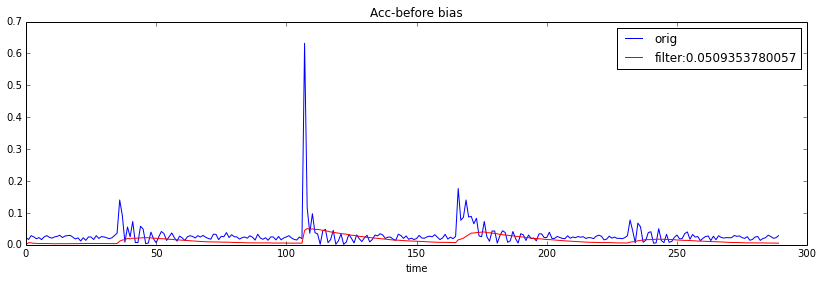

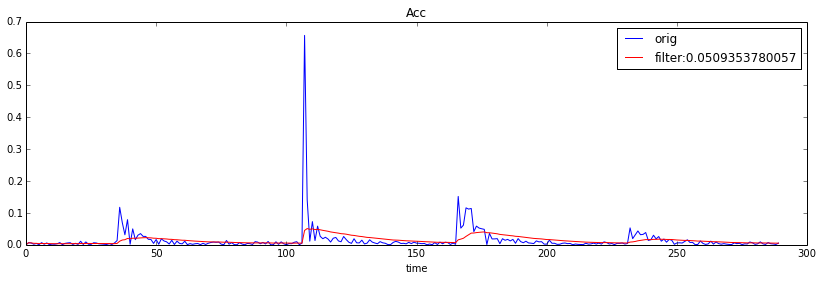

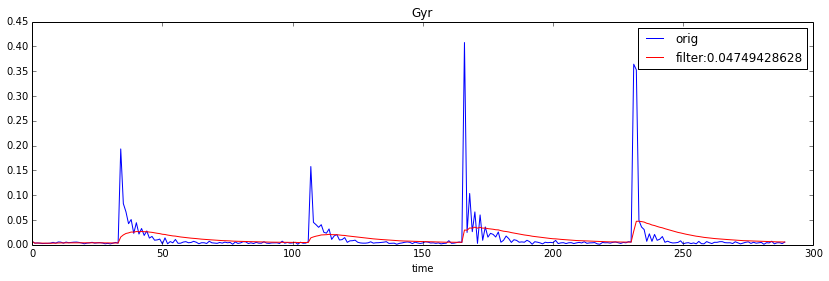

The std of original signal
[ 0.016952    0.03197326  0.04347057  0.03043517  0.01293599  0.02828271
  0.88298118  0.83618021  0.84768554]
The std of energy signal
[ 0.04553449  0.04147334  0.81422315]


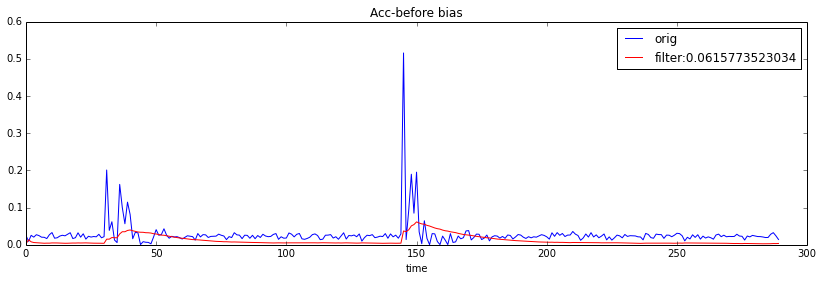

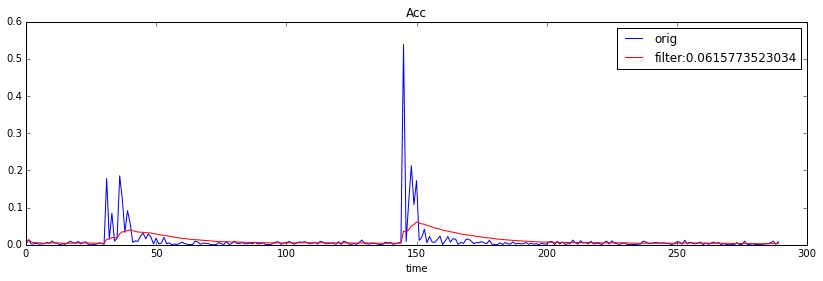

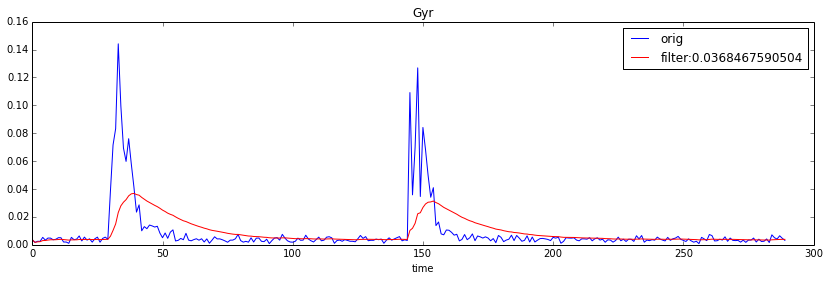

The std of original signal
[ 0.01643795  0.02392081  0.0401755   0.01700137  0.00839194  0.00769314
  0.78890078  0.87015993  0.85559983]
The std of energy signal
[ 0.04170779  0.01859028  0.81784493]


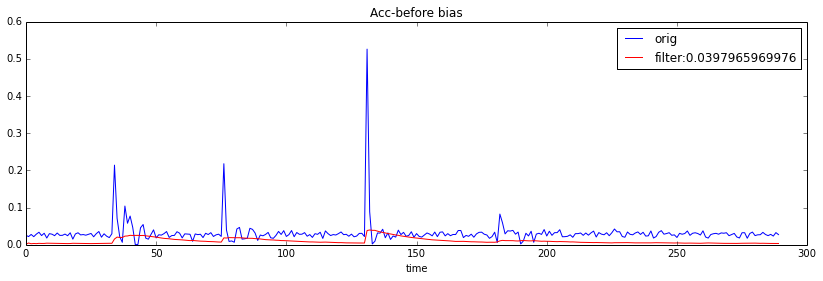

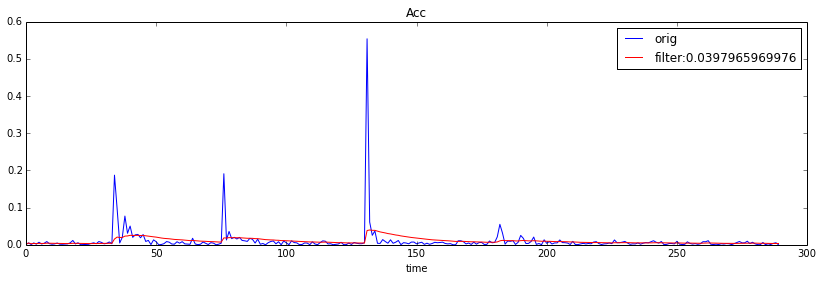

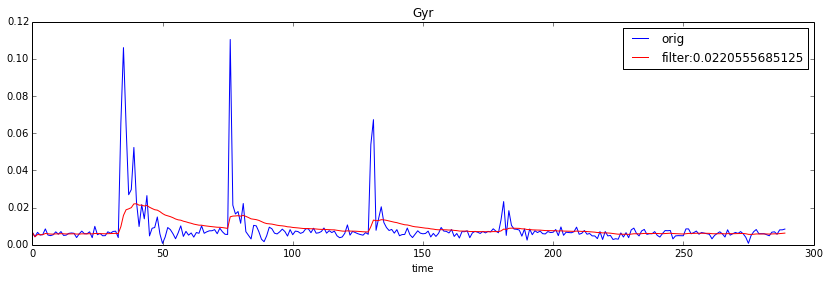

The std of original signal
[ 0.01389657  0.01767168  0.03851782  0.00890991  0.00784244  0.006404
  2.73036453  3.10809673  5.15630347]
The std of energy signal
[ 0.03823218  0.01148213  3.73929275]


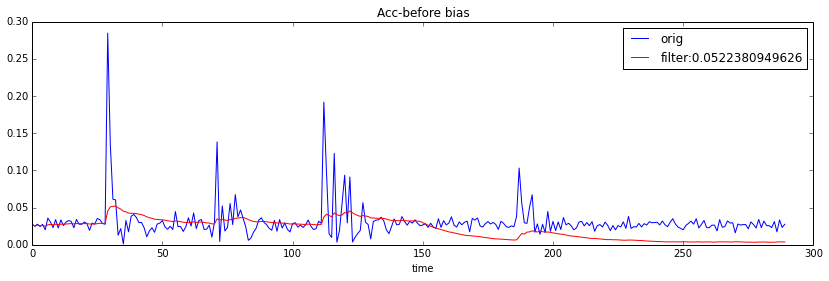

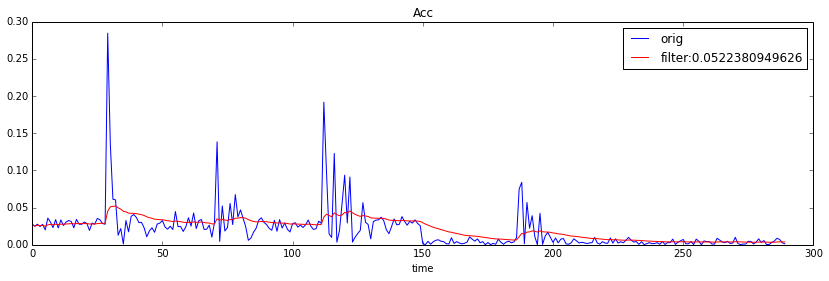

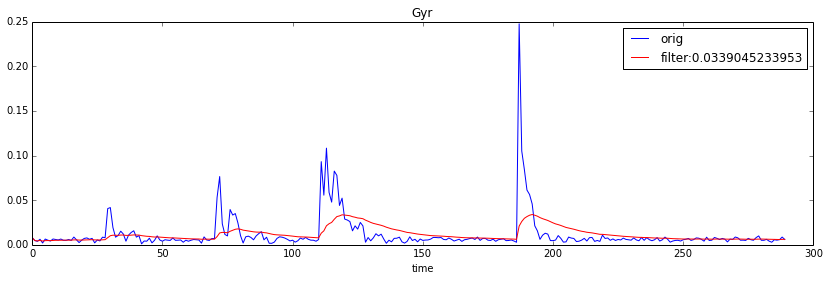

The std of original signal
[ 0.01519104  0.02308947  0.02840231  0.01153979  0.01186267  0.01643989
  0.88153532  0.84576482  0.77217142]
The std of energy signal
[ 0.02857416  0.02107214  0.76103776]


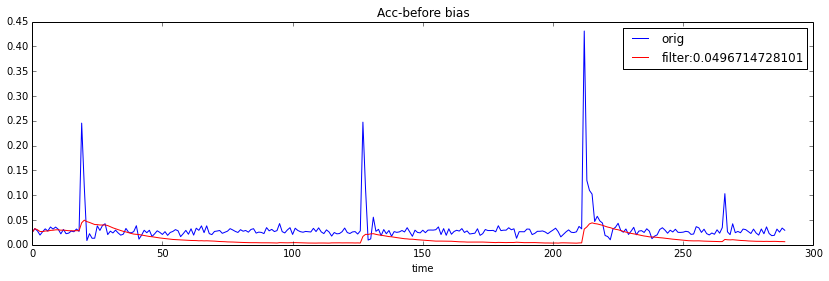

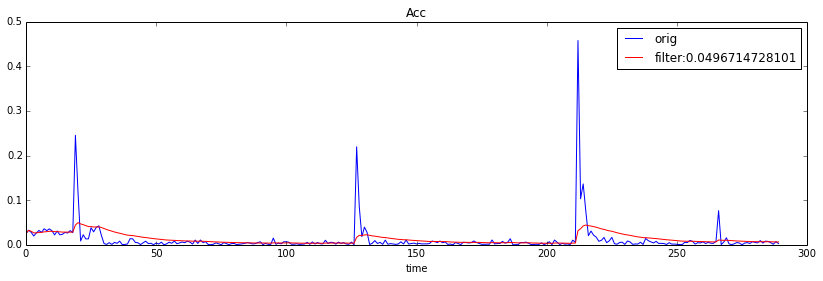

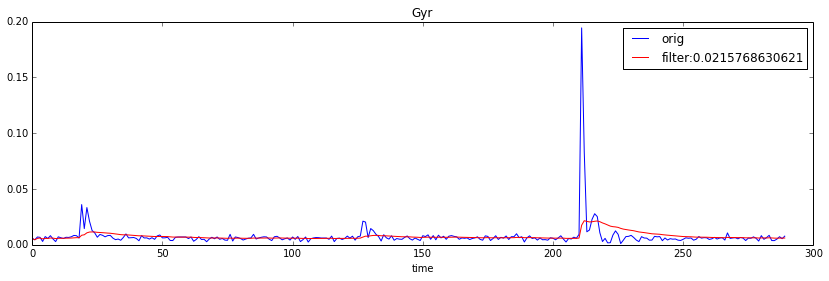

The std of original signal
[  1.32843136e-02   1.88767182e-02   3.52036131e-02   1.12245661e-02
   4.65311378e-03   5.68581801e-03   7.08211640e+00   1.73151074e+01
   2.91935769e+01]
The std of energy signal
[  0.03603231   0.01248678  10.64675398]


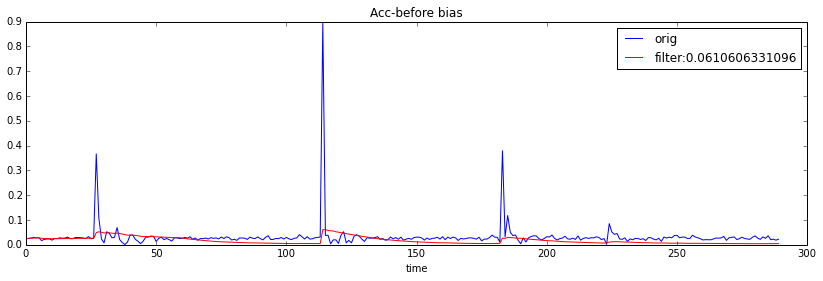

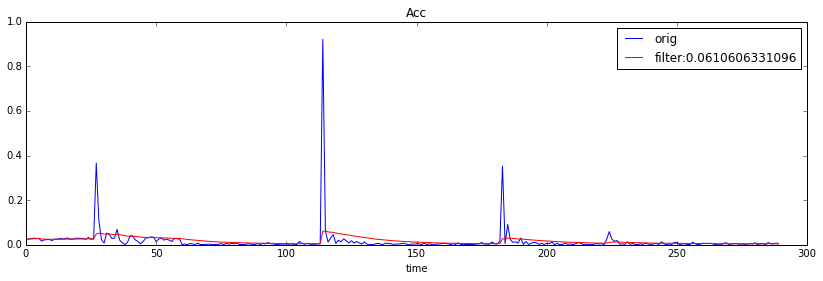

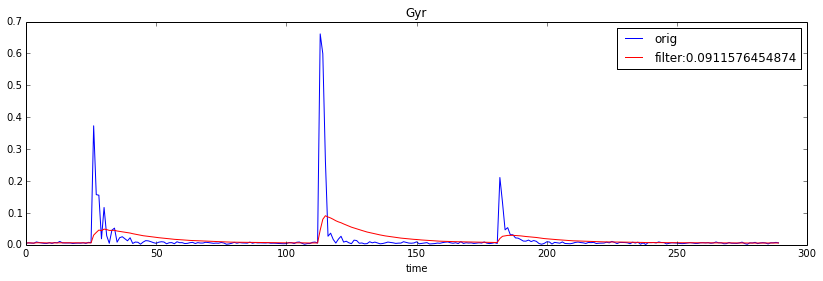

The std of original signal
[  3.09776369e-02   8.87968789e-02   3.35990093e-02   2.11072108e-02
   2.30762053e-02   5.42803073e-02   1.47180203e+01   2.68380685e+01
   9.27186217e+00]
The std of energy signal
[  0.06363421   0.06099783  15.3963551 ]


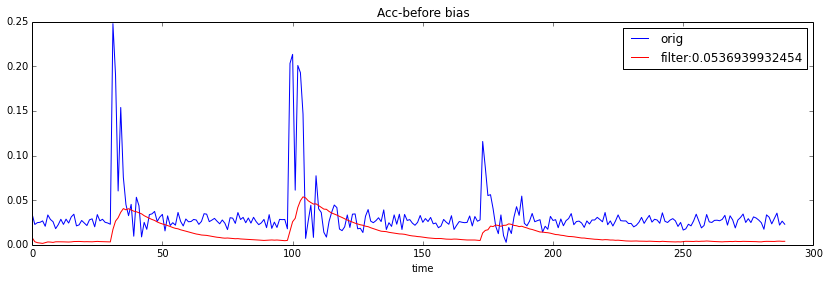

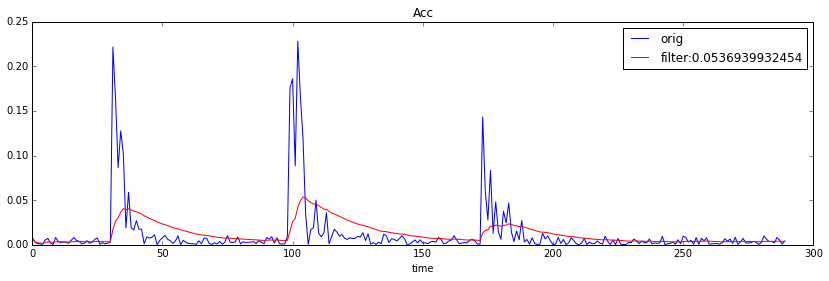

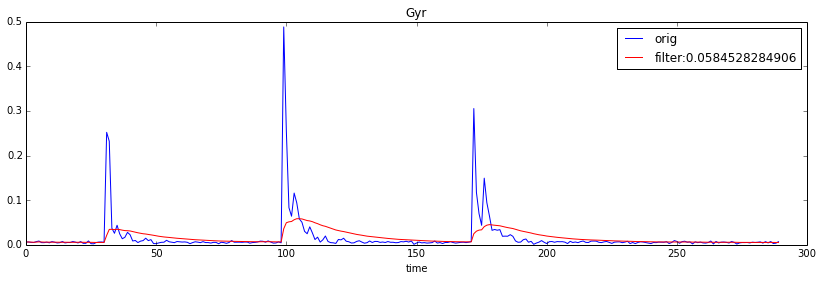

The std of original signal
[  0.04234324   0.02763486   0.08866886   0.02640594   0.02722919
   0.02687822   6.93716925  18.39267382  21.27028835]
The std of energy signal
[  0.03399414   0.04403806  16.55051159]


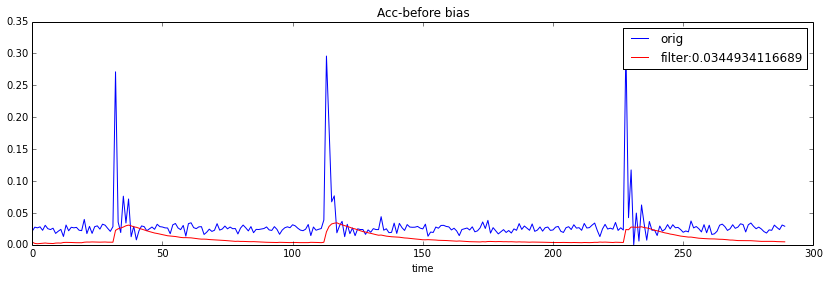

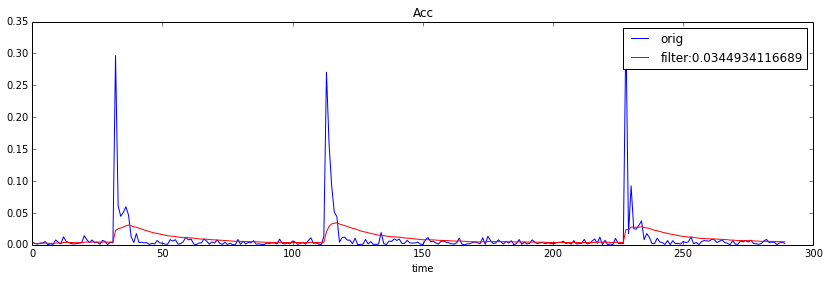

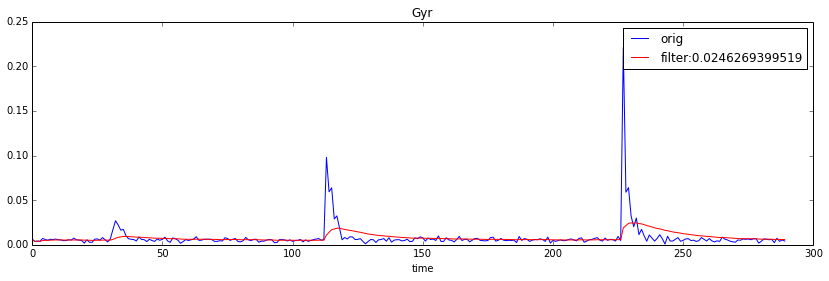

The std of original signal
[  8.78307786e-03   3.60314561e-02   4.22465414e-02   1.45614518e-02
   6.33777189e-03   6.12454857e-03   1.19520073e+01   1.42326039e+01
   1.43223477e+01]
The std of energy signal
[ 0.03457141  0.01562639  9.41566515]


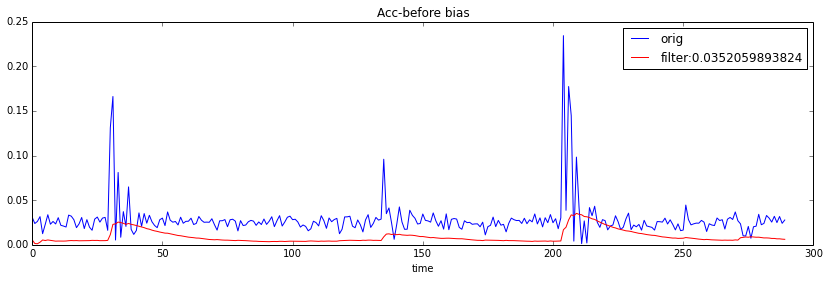

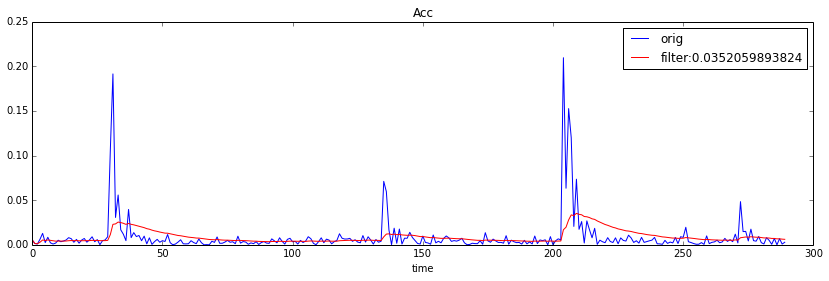

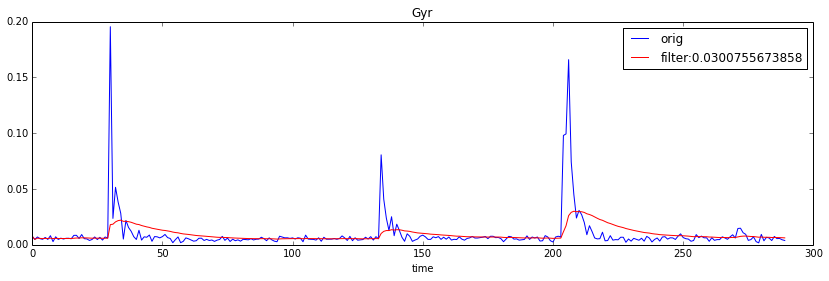

The std of original signal
[  1.65605880e-02   3.47813085e-02   2.86845683e-02   8.93076870e-03
   1.41561353e-02   1.06288162e-02   2.27598477e+01   1.12491257e+01
   1.46792842e+01]
The std of energy signal
[  0.02399943   0.01820897  17.98588306]


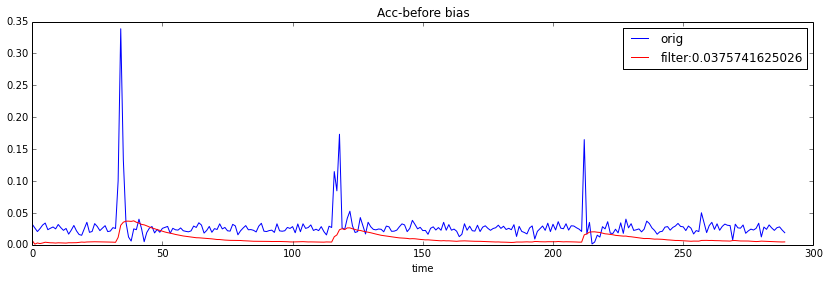

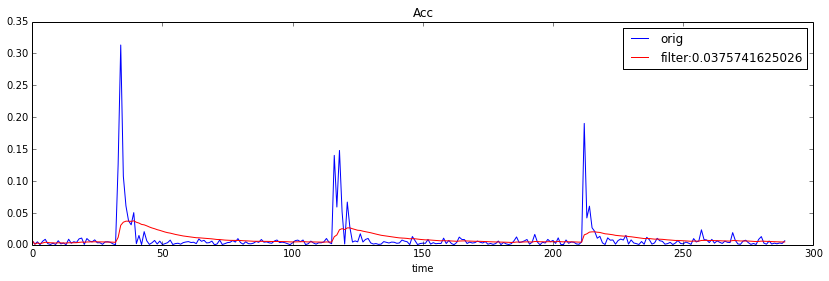

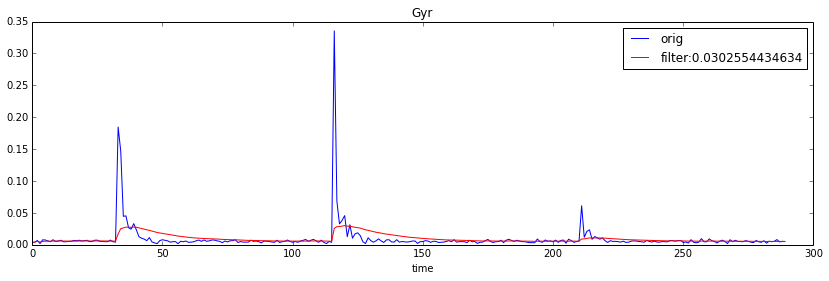

The std of original signal
[  1.80943649e-02   2.53367564e-02   2.79084922e-02   2.29780771e-02
   8.91999532e-03   7.40906658e-03   9.41861921e+00   1.17506608e+01
   9.73585622e+00]
The std of energy signal
[  0.02871346   0.02452759  10.88073741]


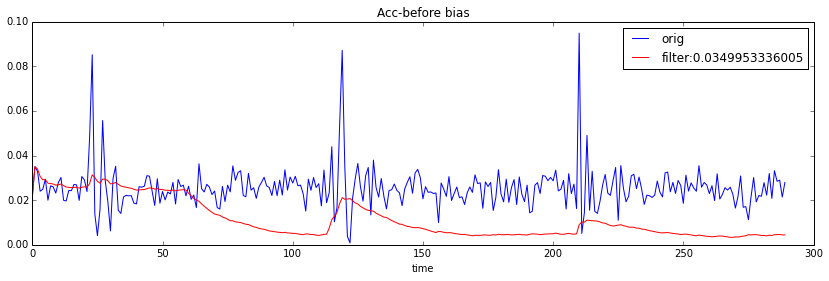

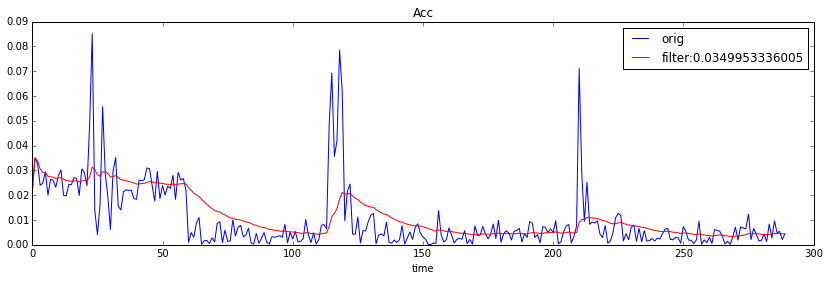

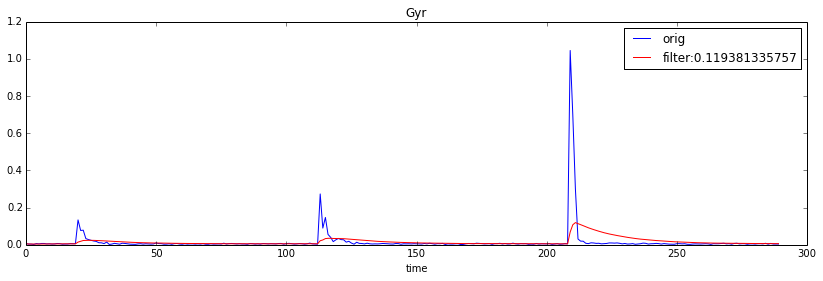

The std of original signal
[  0.01633363   0.0354777    0.01406973   0.06547542   0.01595241
   0.04137466  10.95263529   9.11772001   7.24480153]
The std of energy signal
[  0.01230243   0.07768919  10.02815984]


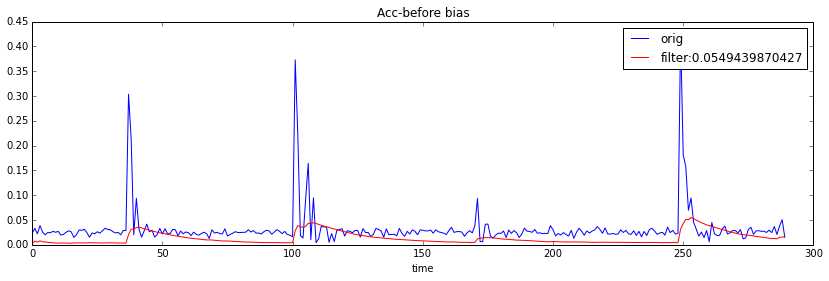

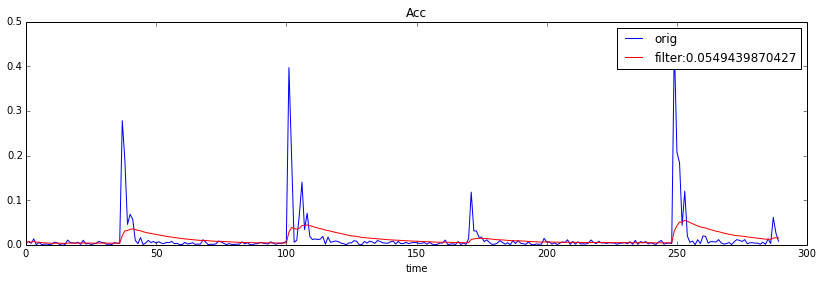

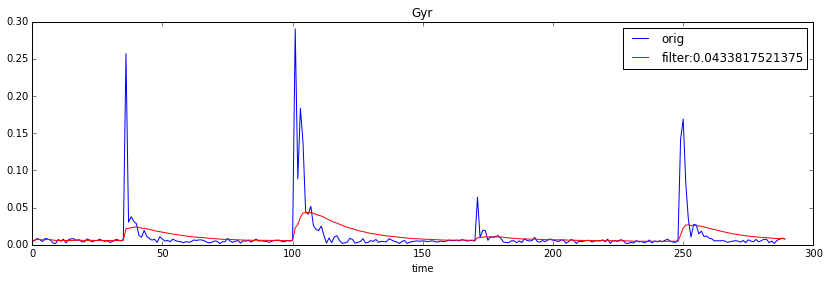

The std of original signal
[  2.58651375e-02   2.71871247e-02   4.84064704e-02   2.16171608e-02
   1.24075984e-02   1.94466608e-02   1.71972505e+01   2.03551103e+01
   1.80276514e+01]
The std of energy signal
[  0.04825901   0.02974834  21.94724574]


In [47]:
if __name__ == '__main__':
    
    dir = '../data/'
    for i in range(1,21):
        fileName = dir + 'motion_vibration' + str(i) + '.txt'
        res_array = getSigs(fileName)
    
        energy_array = energyXYZ(res_array)
    
    
        test(energy_array)

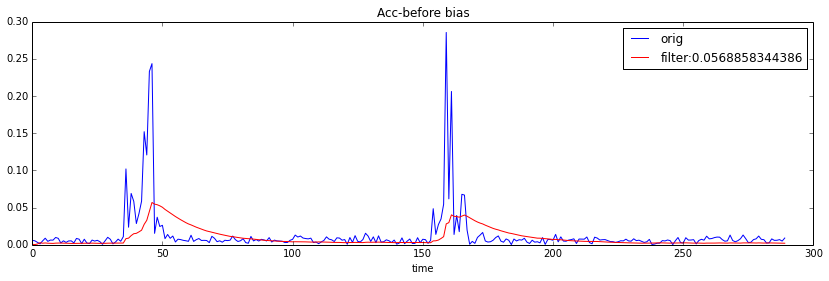

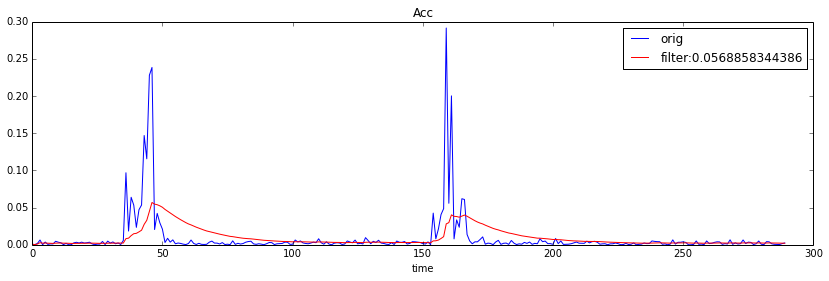

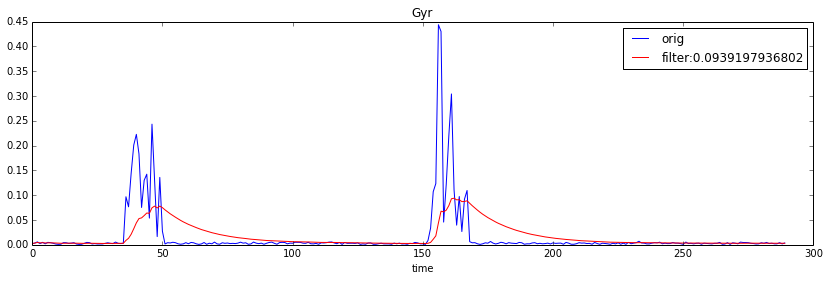

The std of original signal
[ 0.03303194  0.03283416  0.06306427  0.02317417  0.05087237  0.00571164
  0.91685991  0.90815575  0.99678421]
The std of energy signal
[ 0.03269273  0.05352359  0.84134496]


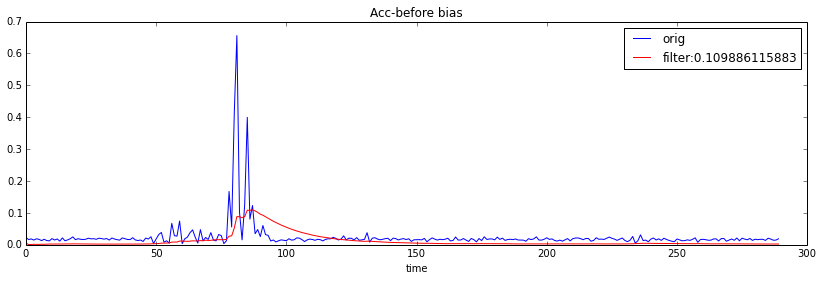

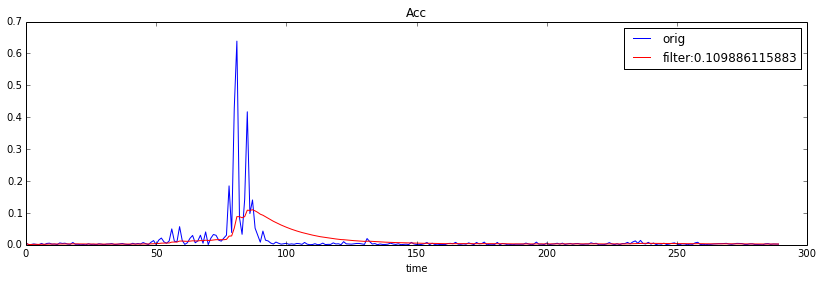

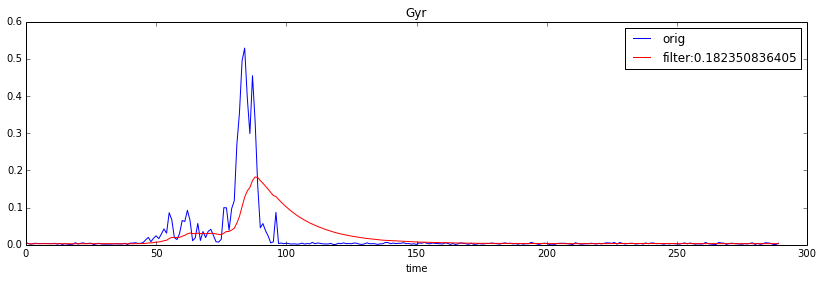

The std of original signal
[ 0.01060513  0.06365874  0.04439295  0.00890625  0.06773246  0.00808465
  1.47872745  0.83585243  2.02903846]
The std of energy signal
[ 0.05520001  0.06721152  1.17631948]


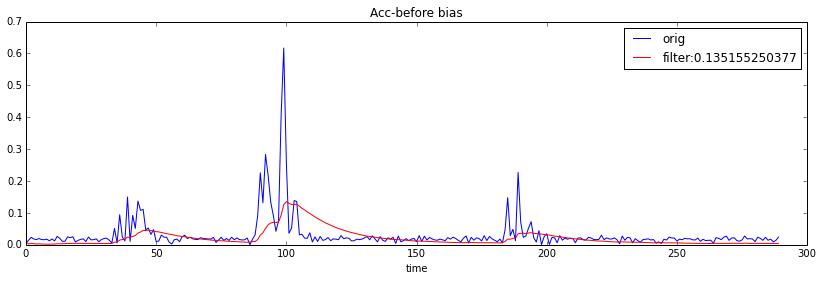

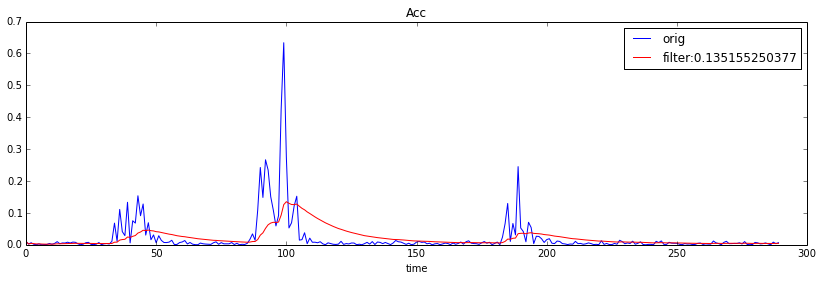

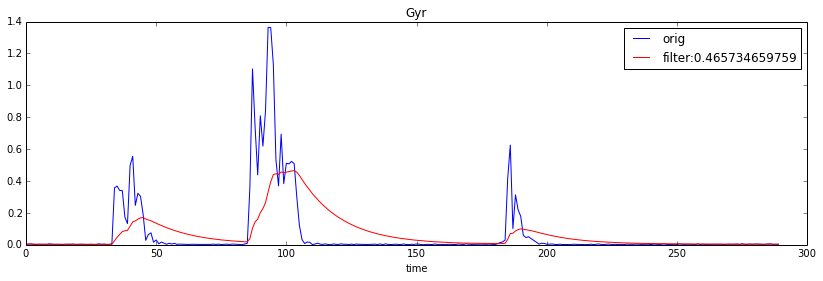

The std of original signal
[ 0.07700441  0.06347595  0.05878427  0.04438441  0.03688999  0.20509547
  1.31873624  1.37118109  0.97152406]
The std of energy signal
[ 0.06318903  0.20163871  0.99665879]


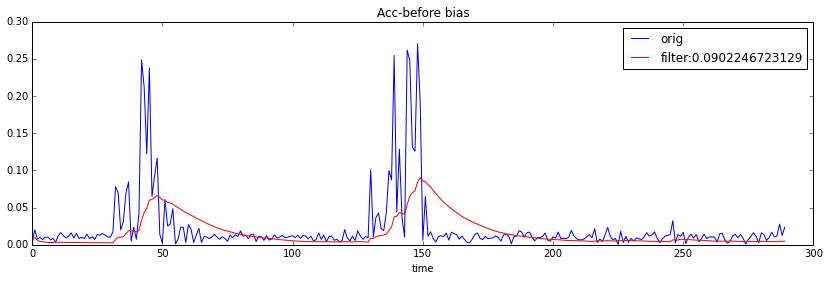

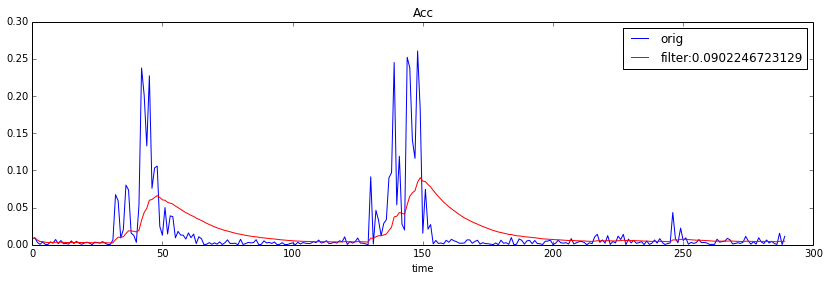

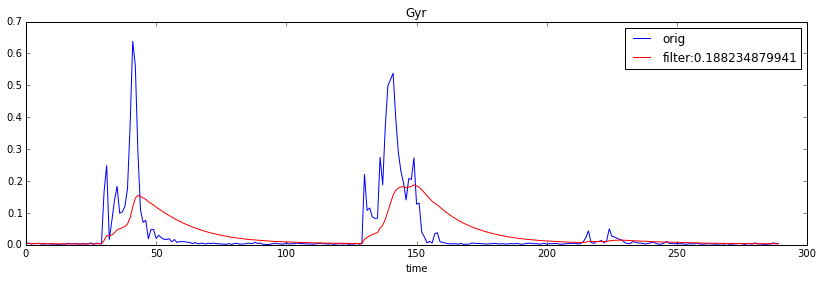

The std of original signal
[ 0.02218312  0.04152386  0.05665684  0.02231373  0.09217807  0.02566612
  0.94509165  1.45739658  1.96924439]
The std of energy signal
[ 0.04519474  0.09369199  1.83504515]


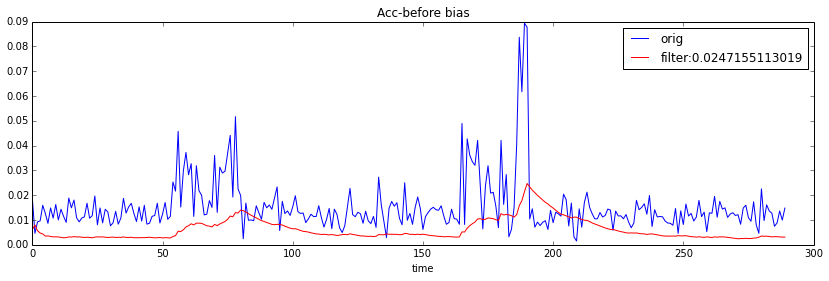

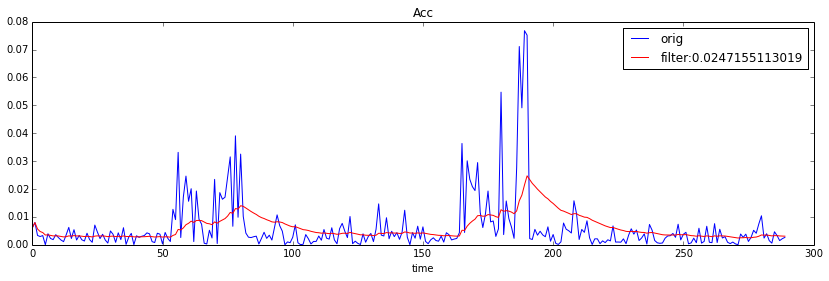

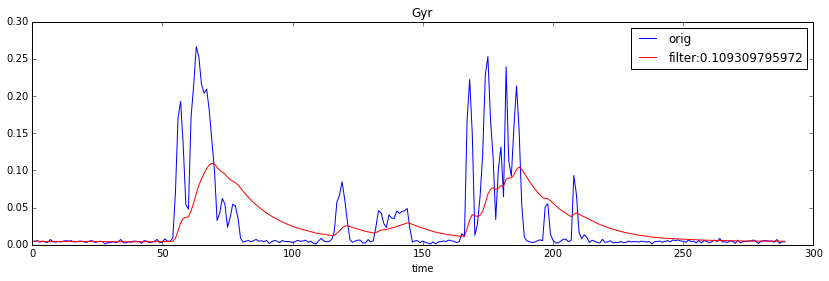

The std of original signal
[  3.17116225e-02   1.05354730e-02   6.82270958e-02   3.68287911e-03
   6.00343928e-02   7.65769391e-03   1.31342645e+00   4.01662580e+00
   8.85479442e+00]
The std of energy signal
[ 0.01174893  0.05393726  7.84575265]


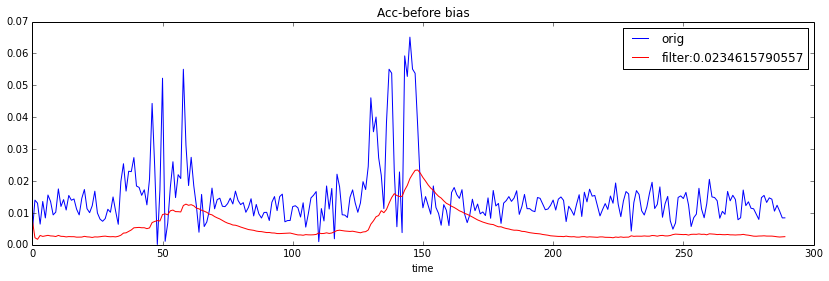

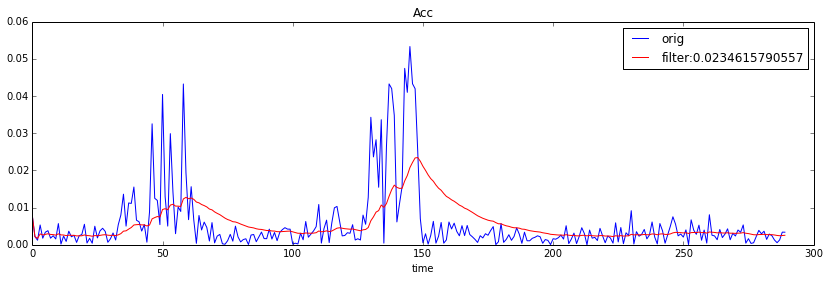

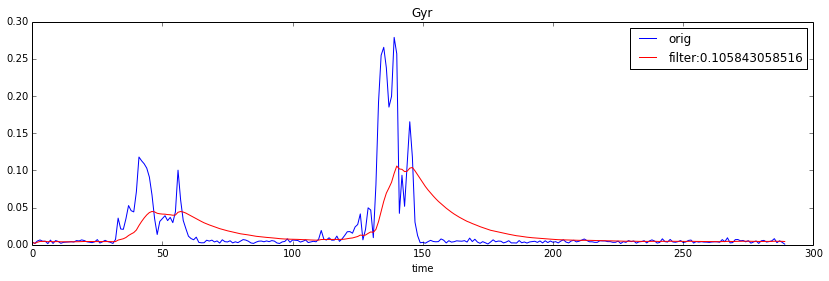

The std of original signal
[  3.09440450e-02   1.03724675e-02   6.01867134e-02   3.66783706e-03
   4.62325547e-02   6.39854482e-03   2.19468417e+00   2.33134893e+00
   9.45243003e+00]
The std of energy signal
[ 0.01020095  0.04307822  6.53174463]


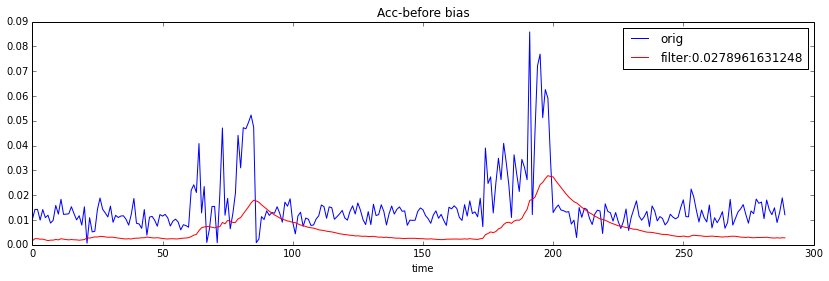

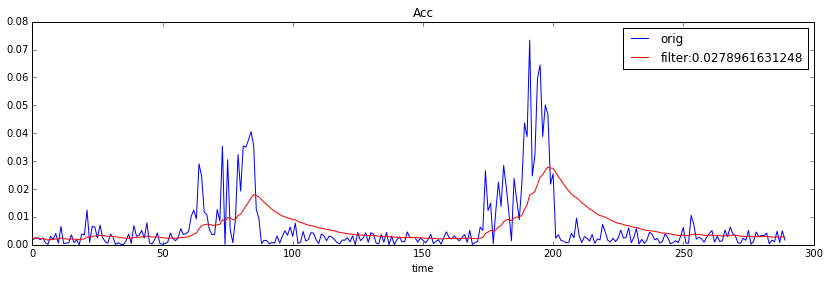

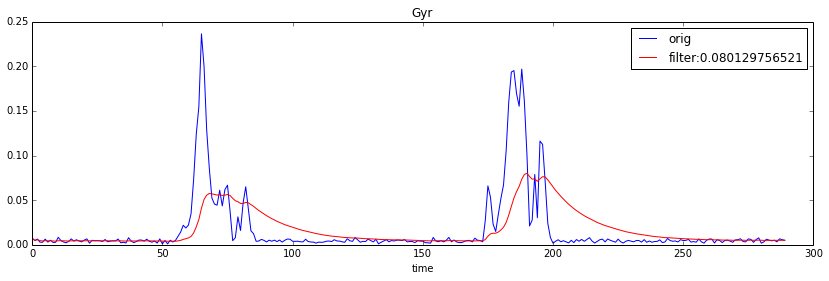

The std of original signal
[  5.18110262e-02   1.29169069e-02   5.64254250e-02   3.75691369e-03
   4.09842240e-02   5.08963252e-03   5.18156707e+00   6.01906482e+00
   1.15165579e+00]
The std of energy signal
[ 0.01235877  0.03770776  5.85339868]


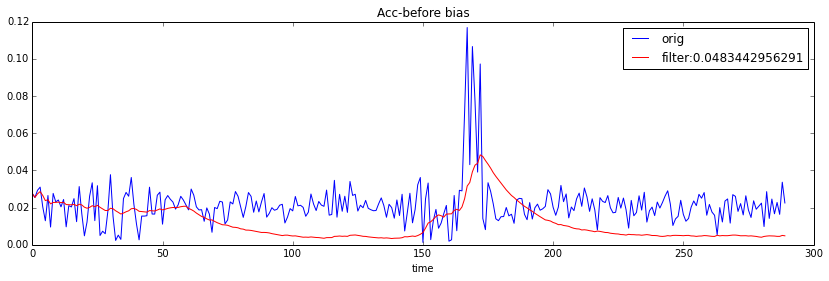

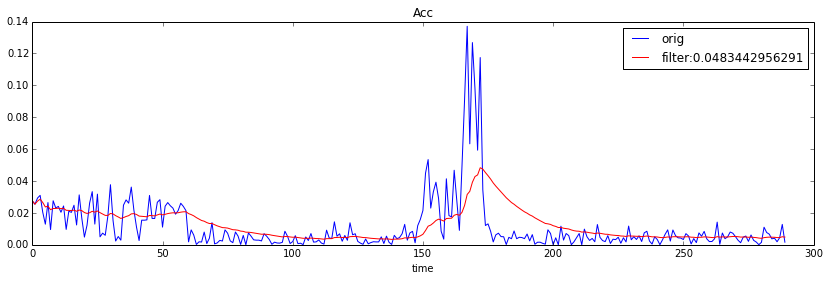

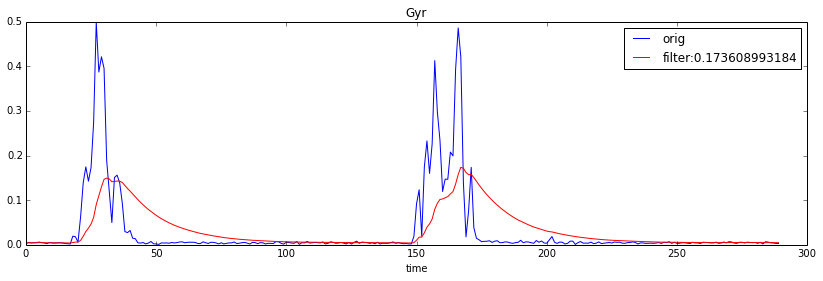

The std of original signal
[ 0.03174074  0.10412624  0.01001666  0.0144679   0.00981625  0.08738433
  0.9841955   2.00086324  2.90197581]
The std of energy signal
[ 0.02009535  0.08320906  3.20688514]


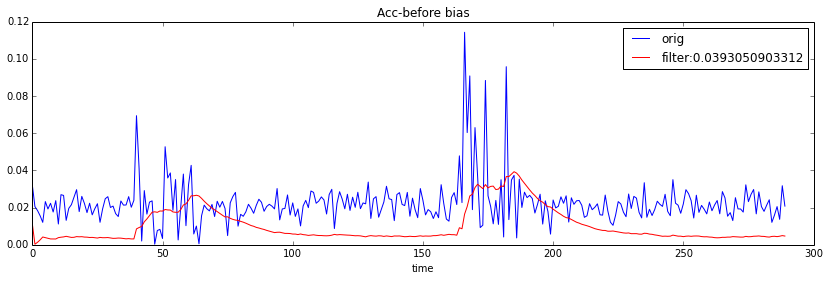

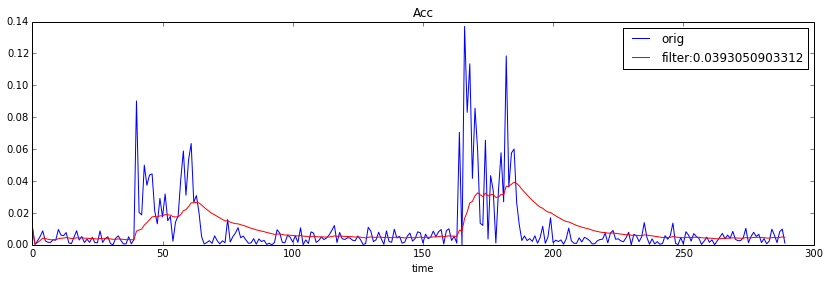

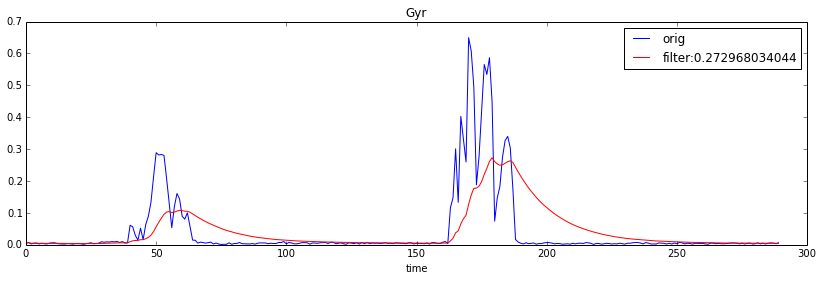

The std of original signal
[ 0.09660502  0.02246756  0.01331534  0.00568843  0.01263149  0.11642003
  2.60401238  2.32391803  1.0077669 ]
The std of energy signal
[ 0.02054839  0.10944298  1.10575541]


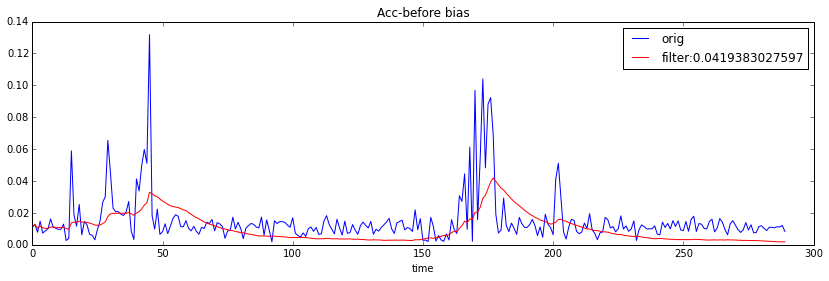

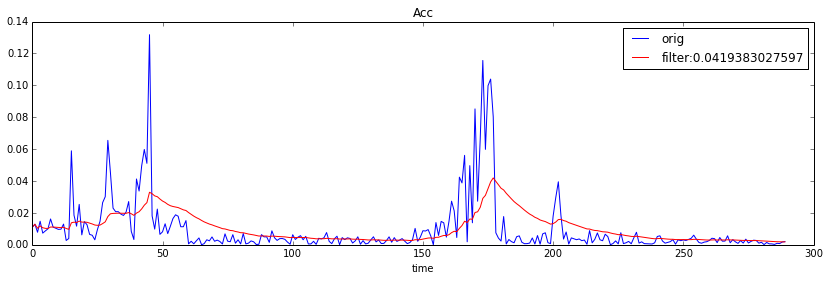

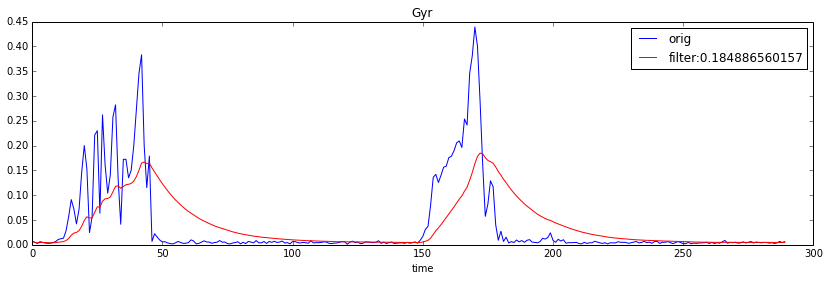

The std of original signal
[  1.43787822e-02   1.74564108e-02   9.33133743e-02   4.99178894e-03
   8.76534152e-02   1.80654093e-02   4.86033250e+00   1.98612725e+00
   6.27371997e+00]
The std of energy signal
[ 0.02062885  0.08042514  4.75476132]


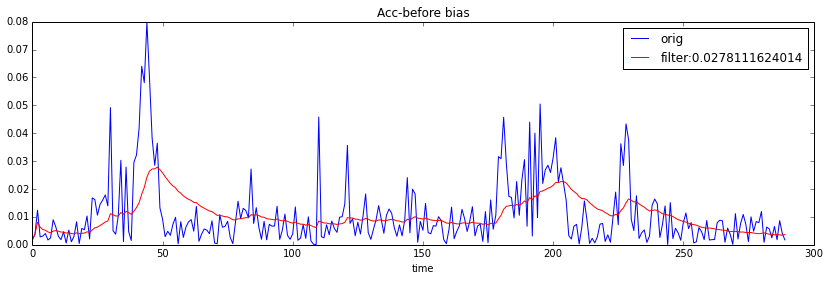

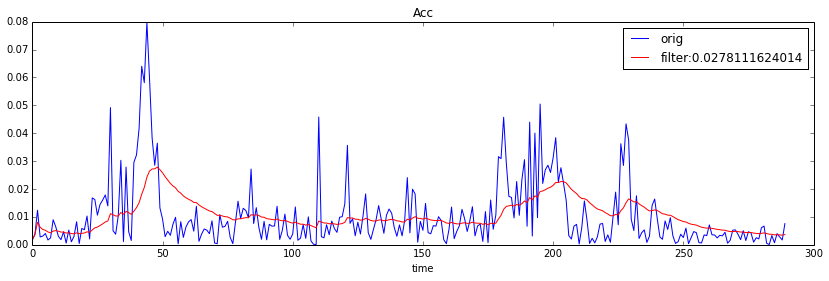

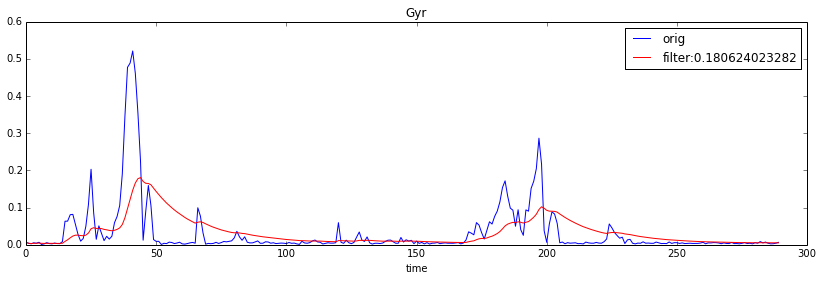

The std of original signal
[  8.30150653e-03   5.25823661e-02   6.45168523e-02   8.12804917e-03
   6.22146749e-02   5.06583452e-02   6.00131873e+00   1.10860604e+01
   2.22994294e+00]
The std of energy signal
[ 0.01364643  0.07375881  6.68080607]


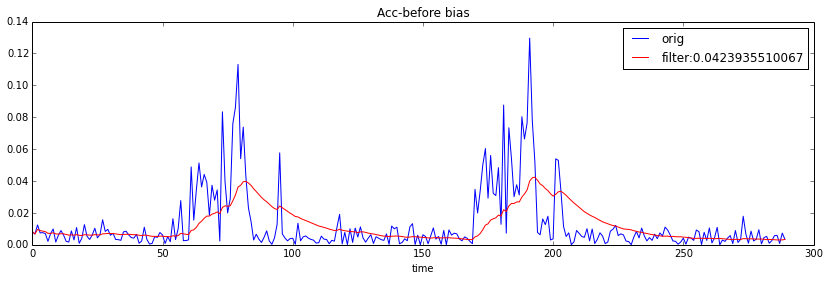

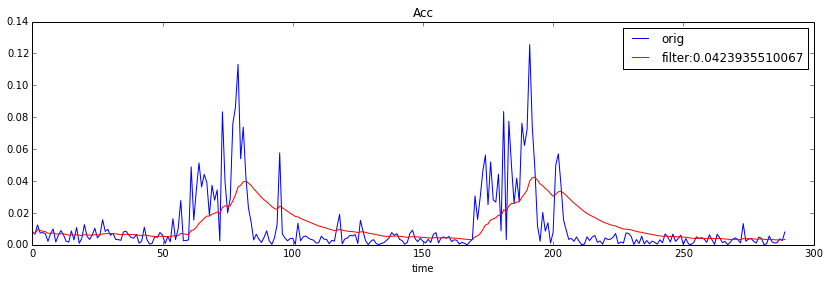

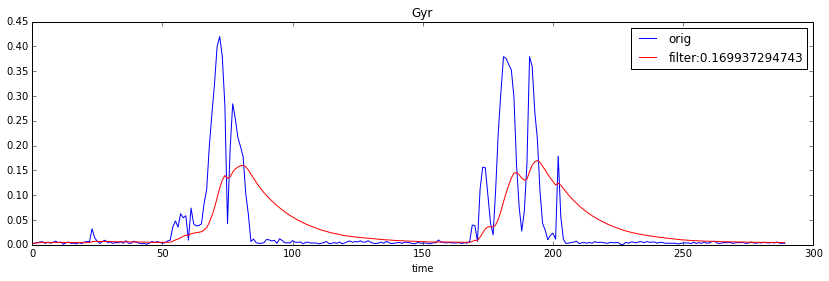

The std of original signal
[ 0.10289789  0.01828357  0.0148415   0.01099178  0.07086684  0.05920629
  2.58986737  3.50710841  5.24883223]
The std of energy signal
[ 0.02133287  0.08519858  2.34329368]


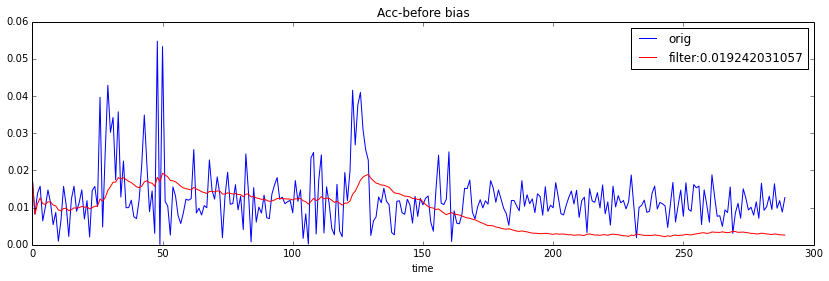

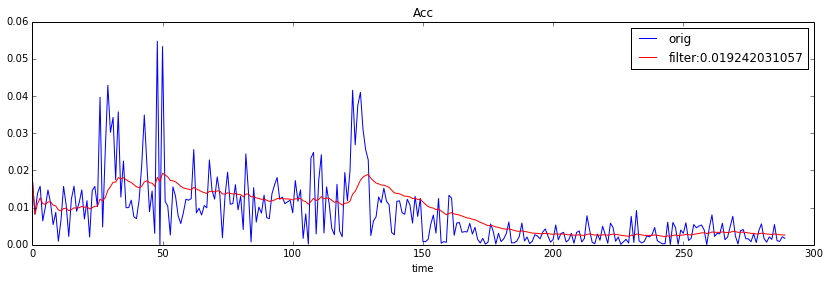

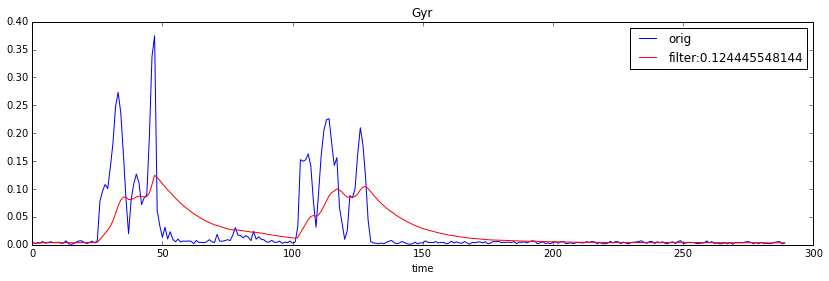

The std of original signal
[ 0.06612948  0.01530914  0.06412539  0.00647427  0.06310094  0.0130181
  1.19748659  2.74328774  5.88846728]
The std of energy signal
[ 0.01261469  0.05862045  5.63797371]


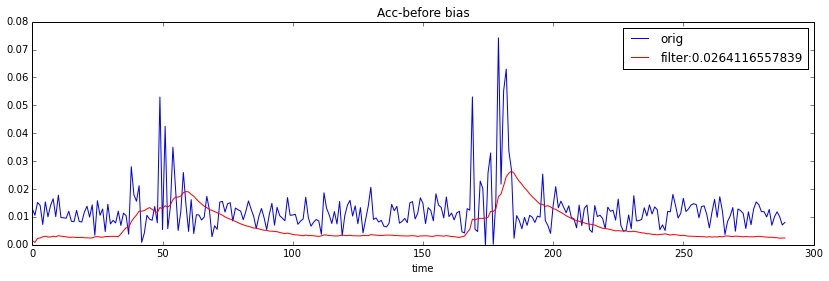

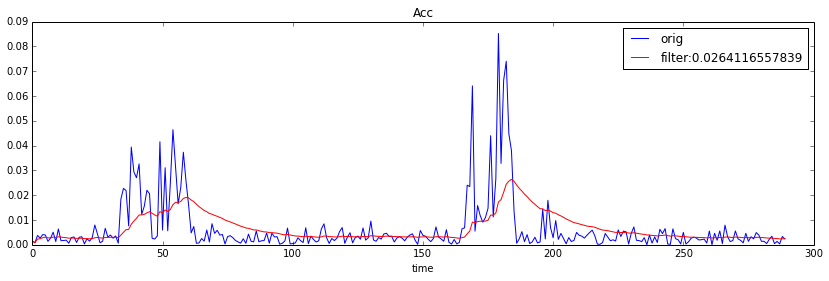

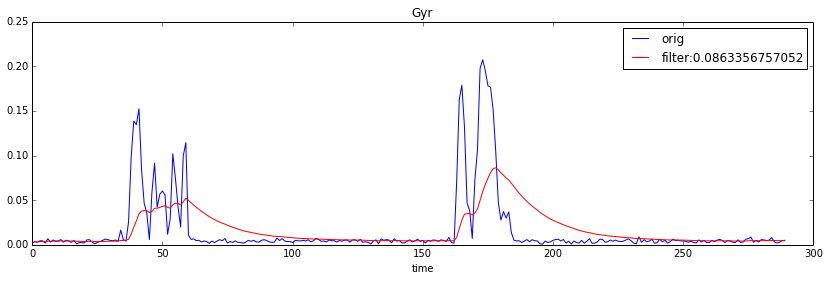

The std of original signal
[  4.26128608e-02   1.11366888e-02   8.00763376e-02   3.38770783e-03
   3.99575723e-02   5.72626348e-03   9.76002971e+00   4.20193909e+00
   4.14680567e+00]
The std of energy signal
[ 0.01273166  0.03696829  6.31436113]


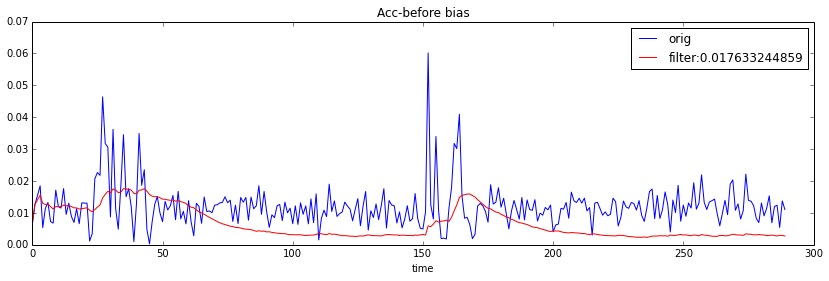

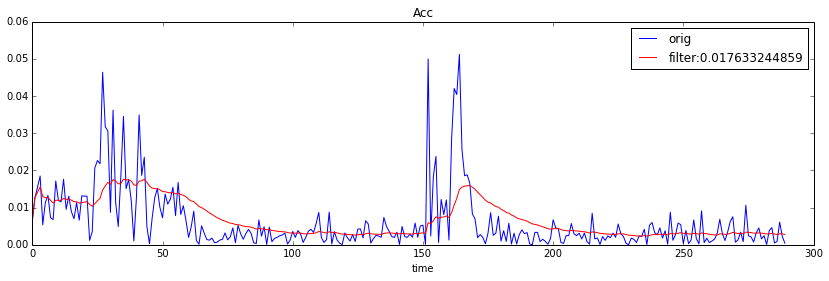

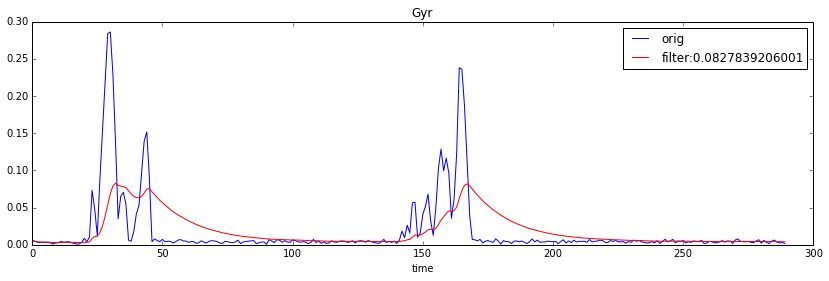

The std of original signal
[  3.90400747e-02   9.78014860e-03   7.09627548e-02   2.96802021e-03
   4.70621561e-02   6.30150962e-03   1.02350608e+01   4.69559336e+00
   4.04186974e+00]
The std of energy signal
[ 0.01084559  0.04415611  6.49710278]


In [48]:
if __name__ == '__main__':
    
    dir = '../data/'
    for i in range(1,16):
        fileName = dir + 'motion_xyz_Move_speedup' + str(i) + '.txt'
        res_array = getSigs(fileName)
    
        energy_array = energyXYZ(res_array)
    
    
        test(energy_array)